In [1]:

from statsmodels.regression.rolling import RollingOLS
#from alpha_vantage.timeseries import TimeSeries
#from nsepython import *
import time
import pandas_datareader.data as web
import matplotlib.pyplot as plt #plotting graphs from data
import statsmodels.api as sm
import pandas as pd #extracting and manipulating dataframes
import numpy as np #for using mathematical functions
import datetime as dt #used to convert string to datetime and creating time offset
import yfinance as yf #extracting data fields related to given stocks
import pandas_ta #calculating technical indicators
import warnings
warnings.filterwarnings('ignore')


In [100]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')
symbols_list = sp500['Symbol'].unique().tolist()

In [101]:
end_date = dt.date.today()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*10)

In [102]:
df = yf.download(tickers=symbols_list, start=start_date, end=end_date, auto_adjust=False).stack()

[*********************100%***********************]  503 of 503 completed


In [103]:
df.index.names = ['date','ticker']
df.columns = df.columns.str.lower()
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-06-29 A        35.778301   38.740002   39.799999   38.740002   39.599998   
           AAPL     27.890593   31.132500   31.617500   31.120001   31.365000   
           ABBV     44.289841   67.180000   70.019997   67.080002   69.269997   
           ABT      40.526905   49.009998   49.849998   48.959999   49.540001   
           ACGL     21.043385   22.129999   22.430000   22.123333   22.396667   
...                       ...         ...         ...         ...         ...   
2025-06-25 XYL     127.470001  127.470001  127.889999  126.570000  127.470001   
           YUM     147.169998  147.169998  149.289993  144.544998  144.960007   
           ZBH      92.750000   92.750000   92.985001   91.750000   91.879997   
           ZBRA    302.730011  302.730011  303.179993  298.825012  300.790009   
           ZTS     157.339996  157.339996  158.699997  155.110001  156.880005   

Price                   volume  
date       ticker               
2015-06-29 A         2516400.0  
           AAPL    196645600.0  
           ABBV     12057200.0  
           ABT       5364300.0  
           ACGL       917700.0  
...                        ...  
2025-06-25 XYL       1101893.0  
           YUM       2978444.0  
           ZBH       2037314.0  
           ZBRA       207299.0  
           ZTS       2200705.0  

[1229976 rows x 6 columns]

In [104]:
#calculating garman_klass_volatility, rsi and bollinger bands
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close']) - np.log(df['open']))**2)
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x,length=20))
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=10).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=10).iloc[:,1])
df['bb_up'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=10).iloc[:,2])
df = df.dropna()
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-07-28 A        37.357567   40.450001   40.470001   39.500000   40.000000   
           AAPL     27.633024   30.844999   30.977501   30.637501   30.844999   
           ABBV     47.308392   71.230003   71.440002   69.080002   69.500000   
           ABT      42.326302   50.939999   51.240002   50.650002   51.090000   
           ACGL     22.136919   23.280001   23.410000   23.236668   23.410000   
...                       ...         ...         ...         ...         ...   
2025-06-25 XYL     127.470001  127.470001  127.889999  126.570000  127.470001   
           YUM     147.169998  147.169998  149.289993  144.544998  144.960007   
           ZBH      92.750000   92.750000   92.985001   91.750000   91.879997   
           ZBRA    302.730011  302.730011  303.179993  298.825012  300.790009   
           ZTS     157.339996  157.339996  158.699997  155.110001  156.880005   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-07-28 A         2768200.0         -0.001510  59.069643  3.618247   
           AAPL    134472400.0         -0.004610  44.772999  3.335115   
           ABBV     10098300.0         -0.056587  66.442580  3.837826   
           ABT       5734900.0         -0.013612  63.907331  3.732685   
           ACGL      1583100.0         -0.001180  65.487947  3.128405   
...                        ...               ...        ...       ...   
2025-06-25 XYL       1101893.0          0.000054  56.654656  4.828755   
           YUM       2978444.0          0.000433  55.360466  4.929088   
           ZBH       2037314.0          0.000055  45.937103  4.506617   
           ZBRA       207299.0          0.000089  59.043286  5.651771   
           ZTS       2200705.0          0.000258  44.587969  5.032411   

Price                bb_mid     bb_up  
date       ticker                      
2015-07-28 A       3.636019  3.653790  
           AAPL    3.381302  3.427490  
           ABBV    3.861598  3.885370  
           ABT     3.757613  3.782541  
           ACGL    3.140794  3.153182  
...                     ...       ...  
2025-06-25 XYL     4.846100  4.863446  
           YUM     4.964082  4.999076  
           ZBH     4.531992  4.557367  
           ZBRA    5.685214  5.718657  
           ZTS     5.087348  5.142284  

[1219916 rows x 11 columns]

In [105]:
#calculating atr
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                       low=stock_data['low'],
                       close=stock_data['close'],
                       length=14)
    #return after normalizing i.e. mean/std.deviation
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-07-28 A        37.357567   40.450001   40.470001   39.500000   40.000000   
           AAPL     27.633024   30.844999   30.977501   30.637501   30.844999   
           ABBV     47.308392   71.230003   71.440002   69.080002   69.500000   
           ABT      42.326302   50.939999   51.240002   50.650002   51.090000   
           ACGL     22.136919   23.280001   23.410000   23.236668   23.410000   
...                       ...         ...         ...         ...         ...   
2025-06-25 XYL     127.470001  127.470001  127.889999  126.570000  127.470001   
           YUM     147.169998  147.169998  149.289993  144.544998  144.960007   
           ZBH      92.750000   92.750000   92.985001   91.750000   91.879997   
           ZBRA    302.730011  302.730011  303.179993  298.825012  300.790009   
           ZTS     157.339996  157.339996  158.699997  155.110001  156.880005   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-07-28 A         2768200.0         -0.001510  59.069643  3.618247   
           AAPL    134472400.0         -0.004610  44.772999  3.335115   
           ABBV     10098300.0         -0.056587  66.442580  3.837826   
           ABT       5734900.0         -0.013612  63.907331  3.732685   
           ACGL      1583100.0         -0.001180  65.487947  3.128405   
...                        ...               ...        ...       ...   
2025-06-25 XYL       1101893.0          0.000054  56.654656  4.828755   
           YUM       2978444.0          0.000433  55.360466  4.929088   
           ZBH       2037314.0          0.000055  45.937103  4.506617   
           ZBRA       207299.0          0.000089  59.043286  5.651771   
           ZTS       2200705.0          0.000258  44.587969  5.032411   

Price                bb_mid     bb_up       atr  
date       ticker                                
2015-07-28 A       3.636019  3.653790       NaN  
           AAPL    3.381302  3.427490       NaN  
           ABBV    3.861598  3.885370       NaN  
           ABT     3.757613  3.782541       NaN  
           ACGL    3.140794  3.153182       NaN  
...                     ...       ...       ...  
2025-06-25 XYL     4.846100  4.863446  0.188256  
           YUM     4.964082  4.999076  1.200692  
           ZBH     4.531992  4.557367 -0.764353  
           ZBRA    5.685214  5.718657  0.008726  
           ZTS     5.087348  5.142284  0.693294  

[1219916 rows x 12 columns]

In [106]:
#computing MACD indicator
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    #return after normalizing i.e. mean/std.deviation
    return ((macd - macd.mean()) / macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-07-28 A        37.357567   40.450001   40.470001   39.500000   40.000000   
           AAPL     27.633024   30.844999   30.977501   30.637501   30.844999   
           ABBV     47.308392   71.230003   71.440002   69.080002   69.500000   
           ABT      42.326302   50.939999   51.240002   50.650002   51.090000   
           ACGL     22.136919   23.280001   23.410000   23.236668   23.410000   
...                       ...         ...         ...         ...         ...   
2025-06-25 XYL     127.470001  127.470001  127.889999  126.570000  127.470001   
           YUM     147.169998  147.169998  149.289993  144.544998  144.960007   
           ZBH      92.750000   92.750000   92.985001   91.750000   91.879997   
           ZBRA    302.730011  302.730011  303.179993  298.825012  300.790009   
           ZTS     157.339996  157.339996  158.699997  155.110001  156.880005   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-07-28 A         2768200.0         -0.001510  59.069643  3.618247   
           AAPL    134472400.0         -0.004610  44.772999  3.335115   
           ABBV     10098300.0         -0.056587  66.442580  3.837826   
           ABT       5734900.0         -0.013612  63.907331  3.732685   
           ACGL      1583100.0         -0.001180  65.487947  3.128405   
...                        ...               ...        ...       ...   
2025-06-25 XYL       1101893.0          0.000054  56.654656  4.828755   
           YUM       2978444.0          0.000433  55.360466  4.929088   
           ZBH       2037314.0          0.000055  45.937103  4.506617   
           ZBRA       207299.0          0.000089  59.043286  5.651771   
           ZTS       2200705.0          0.000258  44.587969  5.032411   

Price                bb_mid     bb_up       atr      macd  
date       ticker                                          
2015-07-28 A       3.636019  3.653790       NaN       NaN  
           AAPL    3.381302  3.427490       NaN       NaN  
           ABBV    3.861598  3.885370       NaN       NaN  
           ABT     3.757613  3.782541       NaN       NaN  
           ACGL    3.140794  3.153182       NaN       NaN  
...                     ...       ...       ...       ...  
2025-06-25 XYL     4.846100  4.863446  0.188256  0.324613  
           YUM     4.964082  4.999076  1.200692 -0.763948  
           ZBH     4.531992  4.557367 -0.764353 -0.476441  
           ZBRA    5.685214  5.718657  0.008726  0.522042  
           ZTS     5.087348  5.142284  0.693294 -0.675096  

[1219916 rows x 13 columns]

In [107]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-07-28 A        37.357567   40.450001   40.470001   39.500000   40.000000   
           AAPL     27.633024   30.844999   30.977501   30.637501   30.844999   
           ABBV     47.308392   71.230003   71.440002   69.080002   69.500000   
           ABT      42.326302   50.939999   51.240002   50.650002   51.090000   
           ACGL     22.136919   23.280001   23.410000   23.236668   23.410000   
...                       ...         ...         ...         ...         ...   
2025-06-25 XYL     127.470001  127.470001  127.889999  126.570000  127.470001   
           YUM     147.169998  147.169998  149.289993  144.544998  144.960007   
           ZBH      92.750000   92.750000   92.985001   91.750000   91.879997   
           ZBRA    302.730011  302.730011  303.179993  298.825012  300.790009   
           ZTS     157.339996  157.339996  158.699997  155.110001  156.880005   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-07-28 A         2768200.0         -0.001510  59.069643  3.618247   
           AAPL    134472400.0         -0.004610  44.772999  3.335115   
           ABBV     10098300.0         -0.056587  66.442580  3.837826   
           ABT       5734900.0         -0.013612  63.907331  3.732685   
           ACGL      1583100.0         -0.001180  65.487947  3.128405   
...                        ...               ...        ...       ...   
2025-06-25 XYL       1101893.0          0.000054  56.654656  4.828755   
           YUM       2978444.0          0.000433  55.360466  4.929088   
           ZBH       2037314.0          0.000055  45.937103  4.506617   
           ZBRA       207299.0          0.000089  59.043286  5.651771   
           ZTS       2200705.0          0.000258  44.587969  5.032411   

Price                bb_mid     bb_up       atr      macd  dollar_volume  
date       ticker                                                         
2015-07-28 A       3.636019  3.653790       NaN       NaN     103.413217  
           AAPL    3.381302  3.427490       NaN       NaN    3715.879086  
           ABBV    3.861598  3.885370       NaN       NaN     477.734331  
           ABT     3.757613  3.782541       NaN       NaN     242.737107  
           ACGL    3.140794  3.153182       NaN       NaN      35.044957  
...                     ...       ...       ...       ...            ...  
2025-06-25 XYL     4.846100  4.863446  0.188256  0.324613     140.458302  
           YUM     4.964082  4.999076  1.200692 -0.763948     438.337598  
           ZBH     4.531992  4.557367 -0.764353 -0.476441     188.960873  
           ZBRA    5.685214  5.718657  0.008726  0.522042      62.755629  
           ZTS     5.087348  5.142284  0.693294 -0.675096     346.258917  

[1219916 rows x 14 columns]

In [108]:
#aggregate to monthly level to reduce training time
#we convert the business daily data to month end frequency
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
data = pd.concat([
    df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
    df.unstack()[last_cols].resample('M').last().stack('ticker')
],axis=1).dropna()
#data is the dataframe containing techincal indicator info about each stock at the end of the month
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-09-30 A           73.013223   31.797485         -0.001607  40.174973   
           AAPL      5814.921905   24.815359         -0.003874  44.191863   
           ABBV       446.173776   36.137173         -0.059472  32.581114   
           ABT        268.201060   33.418999         -0.011689  32.505921   
           ACGL        35.115428   23.287504         -0.000921  63.948063   
...                          ...         ...               ...        ...   
2025-06-30 XYL        140.709273  127.470001          0.000054  56.654656   
           YUM        259.446474  147.169998          0.000433  55.360466   
           ZBH        158.064900   92.750000          0.000055  45.937103   
           ZBRA       128.555001  302.730011          0.000089  59.043286   
           ZTS        470.525057  157.339996          0.000258  44.587969   

                     bb_low    bb_mid     bb_up       atr      macd  
date       ticker                                                    
2015-09-30 A       3.455009  3.502297  3.549585 -1.183044 -0.599052  
           AAPL    3.242391  3.275630  3.308870 -0.915120 -0.283900  
           ABBV    3.558307  3.654713  3.751120 -0.379219 -1.243512  
           ABT     3.495929  3.573271  3.650614 -0.676111 -1.505189  
           ACGL    3.115412  3.158646  3.201881 -0.990596 -0.036170  
...                     ...       ...       ...       ...       ...  
2025-06-30 XYL     4.828755  4.846100  4.863446  0.188256  0.324613  
           YUM     4.929088  4.964082  4.999076  1.200692 -0.763948  
           ZBH     4.506617  4.531992  4.557367 -0.764353 -0.476441  
           ZBRA    5.651771  5.685214  5.718657  0.008726  0.522042  
           ZTS     5.032411  5.087348  5.142284  0.693294 -0.675096  

[57744 rows x 9 columns]

In [109]:
#calculate the 5year rollong avg dollar vol. for each stocks before filtering
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
#ranking the stocks in descending order on dollar vol.
data['dollar_volume_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-09-30 A                 NaN   31.797485         -0.001607  40.174973   
           AAPL              NaN   24.815359         -0.003874  44.191863   
           ABBV              NaN   36.137173         -0.059472  32.581114   
           ABT               NaN   33.418999         -0.011689  32.505921   
           ACGL              NaN   23.287504         -0.000921  63.948063   
...                          ...         ...               ...        ...   
2025-06-30 XYL        130.554041  127.470001          0.000054  56.654656   
           YUM        210.057138  147.169998          0.000433  55.360466   
           ZBH        179.802747   92.750000          0.000055  45.937103   
           ZBRA       131.906048  302.730011          0.000089  59.043286   
           ZTS        362.161682  157.339996          0.000258  44.587969   

                     bb_low    bb_mid     bb_up       atr      macd  \
date       ticker                                                     
2015-09-30 A       3.455009  3.502297  3.549585 -1.183044 -0.599052   
           AAPL    3.242391  3.275630  3.308870 -0.915120 -0.283900   
           ABBV    3.558307  3.654713  3.751120 -0.379219 -1.243512   
           ABT     3.495929  3.573271  3.650614 -0.676111 -1.505189   
           ACGL    3.115412  3.158646  3.201881 -0.990596 -0.036170   
...                     ...       ...       ...       ...       ...   
2025-06-30 XYL     4.828755  4.846100  4.863446  0.188256  0.324613   
           YUM     4.929088  4.964082  4.999076  1.200692 -0.763948   
           ZBH     4.506617  4.531992  4.557367 -0.764353 -0.476441   
           ZBRA    5.651771  5.685214  5.718657  0.008726  0.522042   
           ZTS     5.032411  5.087348  5.142284  0.693294 -0.675096   

                   dollar_volume_rank  
date       ticker                      
2015-09-30 A                      NaN  
           AAPL                   NaN  
           ABBV                   NaN  
           ABT                    NaN  
           ACGL                   NaN  
...                               ...  
2025-06-30 XYL                  390.0  
           YUM                  274.0  
           ZBH                  310.0  
           ZBRA                 387.0  
           ZTS                  150.0  

[57744 rows x 10 columns]

In [110]:
#taking top 150 assets and we dont need dollar vol and dollar vol rank anymore
data = data[data['dollar_volume_rank']<150].drop(['dollar_volume','dollar_volume_rank'], axis=1)
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-08-31 AAPL     24.380814         -0.002442  55.384890  3.227760   
           ABBV     44.219082         -0.053635  44.920131  3.797107   
           ABT      35.773880         -0.012343  41.307080  3.602958   
           ACN      99.638153         -0.007844  52.918803  4.589414   
           ADBE    102.309998          0.000041  61.579876  4.613977   
...                       ...               ...        ...       ...   
2025-06-30 VZ       42.145000          0.000045  44.325164  3.742601   
           WDAY    233.460007          0.000158  39.629315  5.445031   
           WFC      79.074997          0.000100  63.716572  4.274777   
           WMT      97.279999          0.000061  53.613896  4.543827   
           XOM     108.470001          0.000097  51.543589  4.683025   

                     bb_mid     bb_up       atr      macd  
date       ticker                                          
2016-08-31 AAPL    3.248554  3.269348 -1.169939 -0.097714  
           ABBV    3.831325  3.865543 -1.342140 -0.243773  
           ABT     3.635565  3.668173 -1.166713 -0.295116  
           ACN     4.606877  4.624340 -1.231358 -0.086543  
           ADBE    4.628733  4.643489 -1.442093  0.024422  
...                     ...       ...       ...       ...  
2025-06-30 VZ      3.772111  3.801622 -0.630962 -0.906068  
           WDAY    5.492467  5.539903  0.051795 -1.015626  
           WFC     4.332012  4.389247  1.257162  0.982358  
           WMT     4.572513  4.601199  2.193392 -0.213981  
           XOM     4.721946  4.760866  1.043780  1.221337  

[15943 rows x 8 columns]

In [111]:
#calculating returns for different timeframes to capture timeseries dynamics to capture momentum patterns
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]
    for lag in lags:
       df[f'return_{lag}m'] = (
           df['adj close']
           .pct_change(lag)
           .pipe(lambda x : x.clip(lower=x.quantile(outlier_cutoff),
                                  upper=x.quantile(1-outlier_cutoff)))
           .add(1)
           .pow(1/lag)
           .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-08-31 AAPL     38.350464         -0.001592  65.283008  3.624573   
           ABBV     53.960804         -0.038694  68.425752  3.927403   
           ABT      44.438808         -0.005757  62.800522  3.767539   
           ACN     115.659035         -0.005243  59.510446  4.732628   
           ADBE    155.160004          0.000011  64.607687  5.002169   
...                       ...               ...        ...       ...   
2025-06-30 VZ       42.145000          0.000045  44.325164  3.742601   
           WDAY    233.460007          0.000158  39.629315  5.445031   
           WFC      79.074997          0.000100  63.716572  4.274777   
           WMT      97.279999          0.000061  53.613896  4.543827   
           XOM     108.470001          0.000097  51.543589  4.683025   

                     bb_mid     bb_up       atr      macd  return_1m  \
date       ticker                                                      
2017-08-31 AAPL    3.651598  3.678623 -1.014215  0.067797   0.106999   
           ABBV    3.969143  4.010884 -1.346763  0.067048   0.077099   
           ABT     3.792509  3.817479 -1.293194  0.043867   0.035787   
           ACN     4.746404  4.760181 -1.285764 -0.032429   0.015060   
           ADBE    5.027478  5.052787 -1.246982  0.105015   0.059185   
...                     ...       ...       ...       ...        ...   
2025-06-30 VZ      3.772111  3.801622 -0.630962 -0.906068  -0.041288   
           WDAY    5.492467  5.539903  0.051795 -1.015626  -0.057527   
           WFC     4.332012  4.389247  1.257162  0.982358   0.057435   
           WMT     4.572513  4.601199  2.193392 -0.213981  -0.014587   
           XOM     4.721946  4.760866  1.043780  1.221337   0.060313   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-08-31 AAPL     0.069207   0.025287   0.031829   0.046264    0.038469  
           ABBV     0.023627   0.047937   0.036617   0.027342    0.016730  
           ABT      0.026514   0.039058   0.022555   0.034961    0.018239  
           ACN      0.028224   0.016569   0.012675   0.011280    0.012503  
           ADBE     0.047379   0.030323   0.046184   0.046792    0.035313  
...                      ...        ...        ...        ...         ...  
2025-06-30 VZ      -0.021973  -0.019010   0.014434  -0.001616    0.007270  
           WDAY    -0.023835  -0.000100  -0.016539  -0.005080    0.003617  
           WFC      0.058152   0.034627   0.021711   0.039941    0.026172  
           WMT      0.001363   0.035641   0.013264   0.021745    0.031535  
           XOM      0.018010  -0.027253   0.004410  -0.005686   -0.002100  

[13611 rows x 14 columns]

In [112]:
#downloading fama french factors and calculate rolling factors betas
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                            'famafrench',
                            start=pd.to_datetime(end_date) - pd.DateOffset(365*10))[0].drop('RF',axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2015-06-30,-0.0154,0.0290,-0.0082,0.0035,-0.0154
2015-07-31,0.0157,-0.0458,-0.0416,0.0031,-0.0244
2015-08-31,-0.0602,0.0029,0.0275,0.0066,0.0129
2015-09-30,-0.0306,-0.0280,0.0055,0.0180,-0.0059
2015-10-31,0.0775,-0.0206,-0.0047,0.0095,0.0061
...,...,...,...,...,...
2024-12-31,-0.0315,-0.0384,-0.0300,0.0191,-0.0121
2025-01-31,0.0280,-0.0122,0.0162,-0.0233,-0.0324
2025-02-28,-0.0243,-0.0493,0.0491,0.0109,0.0306


In [113]:
#joining 1 month return data with the fama french factors dataframe
factor_data=factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-08-31 AAPL    0.0018 -0.0183 -0.0213  0.0020 -0.0238   0.106999
           ABBV    0.0018 -0.0183 -0.0213  0.0020 -0.0238   0.077099
           ABT     0.0018 -0.0183 -0.0213  0.0020 -0.0238   0.035787
           ACN     0.0018 -0.0183 -0.0213  0.0020 -0.0238   0.015060
           ADBE    0.0018 -0.0183 -0.0213  0.0020 -0.0238   0.059185
...                   ...     ...     ...     ...     ...        ...
2025-04-30 VZ     -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.013058
           WDAY   -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.049116
           WFC    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.010865
           WMT    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.107757
           XOM    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.111830

[13332 rows x 6 columns]

In [114]:
#checking the data by comparing CMA of AAPL and MSFT (they should be same)
factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2017-08-31,0.0018,-0.0183,-0.0213,0.0020,-0.0238,0.106999
2017-09-30,0.0249,0.0476,0.0315,-0.0154,0.0163,-0.060244
2017-10-31,0.0225,-0.0191,0.0013,0.0092,-0.0314,0.096808
2017-11-30,0.0312,-0.0038,-0.0009,0.0319,-0.0010,0.020278
2017-12-31,0.0106,-0.0105,0.0005,0.0073,0.0179,-0.015246


In [115]:
factor_data.xs('MSFT', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2017-08-31,0.0018,-0.0183,-0.0213,0.0020,-0.0238,0.033952
2017-09-30,0.0249,0.0476,0.0315,-0.0154,0.0163,-0.003745
2017-10-31,0.0225,-0.0191,0.0013,0.0092,-0.0314,0.116660
2017-11-30,0.0312,-0.0038,-0.0009,0.0319,-0.0010,0.016984
2017-12-31,0.0106,-0.0105,0.0005,0.0073,0.0179,0.016276


In [116]:
# filter out stocks with less than 10 months of data
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
valid_stocks

ticker
AAPL    93
ABBV    93
ABNB    28
ABT     93
ACN     93
        ..
WFC     93
WMT     93
WYNN    71
XOM     93
YUM     10
Length: 176, dtype: int64

In [117]:
#getting factor data for valid stocks
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-08-31 AAPL    0.0018 -0.0183 -0.0213  0.0020 -0.0238   0.106999
           ABBV    0.0018 -0.0183 -0.0213  0.0020 -0.0238   0.077099
           ABT     0.0018 -0.0183 -0.0213  0.0020 -0.0238   0.035787
           ACN     0.0018 -0.0183 -0.0213  0.0020 -0.0238   0.015060
           ADBE    0.0018 -0.0183 -0.0213  0.0020 -0.0238   0.059185
...                   ...     ...     ...     ...     ...        ...
2025-04-30 VZ     -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.013058
           WDAY   -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.049116
           WFC    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.010865
           WMT    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.107757
           XOM    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.111830

[13297 rows x 6 columns]

In [118]:
#calculating rolling factor betas
betas = (factor_data.groupby(
            level=1,
            group_keys=False)
        .apply(lambda x : RollingOLS(
            endog=x['return_1m'],
            exog=sm.add_constant(x.drop('return_1m',axis=1)),
            window=min(24,x.shape[0]),
            min_nobs=len(x.columns)+1)
            .fit(params_only=True)
              .params
              .drop('const',axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-08-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-04-30 VZ      0.903033 -1.057594  0.910843  0.657690 -0.078019
           WDAY    1.108715 -0.937077  0.037348 -1.896113 -0.421493
           WFC     0.877760 -0.095226  0.559152 -1.655161 -0.085205
           WMT     0.787318  0.091155 -0.722453  0.394668  0.633494
           XOM     0.476822 -0.287362  1.039671  1.215637  0.114549

[13297 rows x 5 columns]

In [119]:
# shifting the rolling factor betas one month forward because we cannot join them to the same month as the values were not
# known then.
data = (data.join(betas.groupby('ticker').shift()))


In [120]:
#filling all the missing values of factors with mean
factors = ['Mkt-RF','SMB','HML','RMW','CMA']
data.loc[:,factors] = data.groupby('ticker',group_keys=False)[factors].apply(lambda x : x.fillna(x.mean()))

In [121]:
#dropping null values and adjusted close column
data = data.dropna()
data = data.drop('adj close',axis=1)
#printing column names
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13347 entries, (Timestamp('2017-08-31 00:00:00'), 'AAPL') to (Timestamp('2025-06-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  13347 non-null  float64
 1   rsi               13347 non-null  float64
 2   bb_low            13347 non-null  float64
 3   bb_mid            13347 non-null  float64
 4   bb_up             13347 non-null  float64
 5   atr               13347 non-null  float64
 6   macd              13347 non-null  float64
 7   return_1m         13347 non-null  float64
 8   return_2m         13347 non-null  float64
 9   return_3m         13347 non-null  float64
 10  return_6m         13347 non-null  float64
 11  return_9m         13347 non-null  float64
 12  return_12m        13347 non-null  float64
 13  Mkt-RF            13347 non-null  float64
 14  SMB               13347 non-null  float64
 15  HML       

In [122]:
data

garman_klass_vol        rsi    bb_low    bb_mid     bb_up  \
date       ticker                                                              
2017-08-31 AAPL           -0.001592  65.283008  3.624573  3.651598  3.678623   
           ABBV           -0.038694  68.425752  3.927403  3.969143  4.010884   
           ABT            -0.005757  62.800522  3.767539  3.792509  3.817479   
           ACN            -0.005243  59.510446  4.732628  4.746404  4.760181   
           ADBE            0.000011  64.607687  5.002169  5.027478  5.052787   
...                             ...        ...       ...       ...       ...   
2025-06-30 VZ              0.000045  44.325164  3.742601  3.772111  3.801622   
           WDAY            0.000158  39.629315  5.445031  5.492467  5.539903   
           WFC             0.000100  63.716572  4.274777  4.332012  4.389247   
           WMT             0.000061  53.613896  4.543827  4.572513  4.601199   
           XOM             0.000097  51.543589  4.683025  4.721946  4.760866   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-08-31 AAPL   -1.014215  0.067797   0.106999   0.069207   0.025287   
           ABBV   -1.346763  0.067048   0.077099   0.023627   0.047937   
           ABT    -1.293194  0.043867   0.035787   0.026514   0.039058   
           ACN    -1.285764 -0.032429   0.015060   0.028224   0.016569   
           ADBE   -1.246982  0.105015   0.059185   0.047379   0.030323   
...                     ...       ...        ...        ...        ...   
2025-06-30 VZ     -0.630962 -0.906068  -0.041288  -0.021973  -0.019010   
           WDAY    0.051795 -1.015626  -0.057527  -0.023835  -0.000100   
           WFC     1.257162  0.982358   0.057435   0.058152   0.034627   
           WMT     2.193392 -0.213981  -0.014587   0.001363   0.035641   
           XOM     1.043780  1.221337   0.060313   0.018010  -0.027253   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-08-31 AAPL     0.031829   0.046264    0.038469  1.226708 -0.105072   
           ABBV     0.036617   0.027342    0.016730  0.473128  0.190917   
           ABT      0.022555   0.034961    0.018239  0.839358 -0.178015   
           ACN      0.012675   0.011280    0.012503  1.145539 -0.174608   
           ADBE     0.046184   0.046792    0.035313  1.232803 -0.443374   
...                      ...        ...         ...       ...       ...   
2025-06-30 VZ       0.014434  -0.001616    0.007270  0.561784 -0.488953   
           WDAY    -0.016539  -0.005080    0.003617  1.131538 -0.821464   
           WFC      0.021711   0.039941    0.026172  1.051505 -0.076360   
           WMT      0.013264   0.021745    0.031535  0.635353 -0.320838   
           XOM      0.004410  -0.005686   -0.002100  1.040658  0.197619   

                        HML       RMW       CMA  
date       ticker                                
2017-08-31 AAPL   -0.605704  0.620149  0.263183  
           ABBV    0.044039  0.040175  0.336977  
           ABT    -0.442236  0.096294  1.031715  
           ACN    -0.308559  0.077241  0.073080  
           ADBE   -0.145299 -0.100840 -0.672944  
...                     ...       ...       ...  
2025-06-30 VZ      0.172003  0.318720  0.432862  
           WDAY   -0.353326 -1.284383 -0.274655  
           WFC     1.321495 -0.800788 -0.544757  
           WMT    -0.315028  0.523504  0.634127  
           XOM     0.535742 -0.153491  0.741763  

[13347 rows x 18 columns]

In [123]:
#applying K-means clustering from sklearn
from sklearn.cluster import KMeans

In [124]:
#giving pre defined centroids
#also setting cluster number to rsi so that only one cluster always give stocks with highest rsi
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values),18))
initial_centroids[:,1] = target_rsi_values
initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [125]:
#making clusters for each month no. of clusters = 4
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4,
                          random_state = 0,
                          init = initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date',group_keys = False).apply(get_clusters)
data

garman_klass_vol        rsi    bb_low    bb_mid     bb_up  \
date       ticker                                                              
2017-08-31 AAPL           -0.001592  65.283008  3.624573  3.651598  3.678623   
           ABBV           -0.038694  68.425752  3.927403  3.969143  4.010884   
           ABT            -0.005757  62.800522  3.767539  3.792509  3.817479   
           ACN            -0.005243  59.510446  4.732628  4.746404  4.760181   
           ADBE            0.000011  64.607687  5.002169  5.027478  5.052787   
...                             ...        ...       ...       ...       ...   
2025-06-30 VZ              0.000045  44.325164  3.742601  3.772111  3.801622   
           WDAY            0.000158  39.629315  5.445031  5.492467  5.539903   
           WFC             0.000100  63.716572  4.274777  4.332012  4.389247   
           WMT             0.000061  53.613896  4.543827  4.572513  4.601199   
           XOM             0.000097  51.543589  4.683025  4.721946  4.760866   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-08-31 AAPL   -1.014215  0.067797   0.106999   0.069207   0.025287   
           ABBV   -1.346763  0.067048   0.077099   0.023627   0.047937   
           ABT    -1.293194  0.043867   0.035787   0.026514   0.039058   
           ACN    -1.285764 -0.032429   0.015060   0.028224   0.016569   
           ADBE   -1.246982  0.105015   0.059185   0.047379   0.030323   
...                     ...       ...        ...        ...        ...   
2025-06-30 VZ     -0.630962 -0.906068  -0.041288  -0.021973  -0.019010   
           WDAY    0.051795 -1.015626  -0.057527  -0.023835  -0.000100   
           WFC     1.257162  0.982358   0.057435   0.058152   0.034627   
           WMT     2.193392 -0.213981  -0.014587   0.001363   0.035641   
           XOM     1.043780  1.221337   0.060313   0.018010  -0.027253   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-08-31 AAPL     0.031829   0.046264    0.038469  1.226708 -0.105072   
           ABBV     0.036617   0.027342    0.016730  0.473128  0.190917   
           ABT      0.022555   0.034961    0.018239  0.839358 -0.178015   
           ACN      0.012675   0.011280    0.012503  1.145539 -0.174608   
           ADBE     0.046184   0.046792    0.035313  1.232803 -0.443374   
...                      ...        ...         ...       ...       ...   
2025-06-30 VZ       0.014434  -0.001616    0.007270  0.561784 -0.488953   
           WDAY    -0.016539  -0.005080    0.003617  1.131538 -0.821464   
           WFC      0.021711   0.039941    0.026172  1.051505 -0.076360   
           WMT      0.013264   0.021745    0.031535  0.635353 -0.320838   
           XOM      0.004410  -0.005686   -0.002100  1.040658  0.197619   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-08-31 AAPL   -0.605704  0.620149  0.263183        3  
           ABBV    0.044039  0.040175  0.336977        3  
           ABT    -0.442236  0.096294  1.031715        3  
           ACN    -0.308559  0.077241  0.073080        2  
           ADBE   -0.145299 -0.100840 -0.672944        3  
...                     ...       ...       ...      ...  
2025-06-30 VZ      0.172003  0.318720  0.432862        1  
           WDAY   -0.353326 -1.284383 -0.274655        0  
           WFC     1.321495 -0.800788 -0.544757        3  
           WMT    -0.315028  0.523504  0.634127        2  
           XOM     0.535742 -0.153491  0.741763        2  

[13347 rows x 19 columns]

In [126]:
#for showing scatter plot
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
    #using atr as x axis and rsi as y axis
    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    plt.legend()
    plt.show()
    return

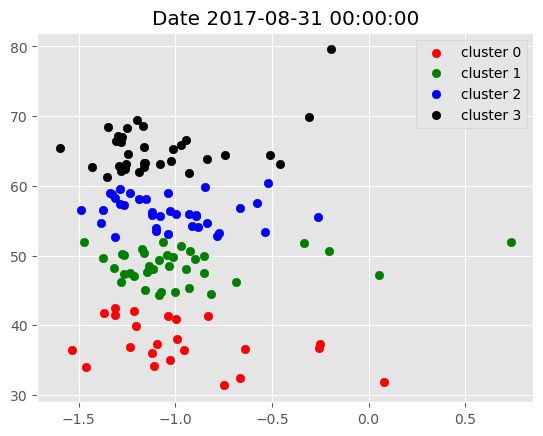

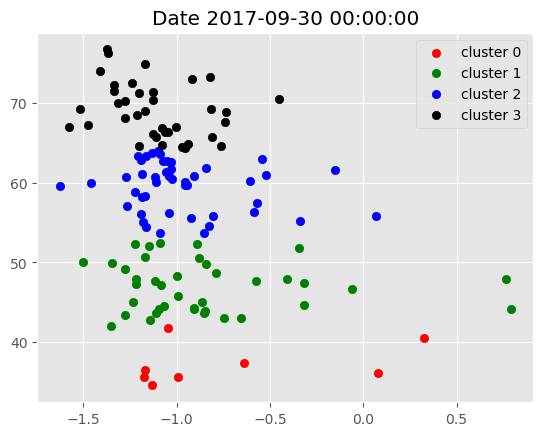

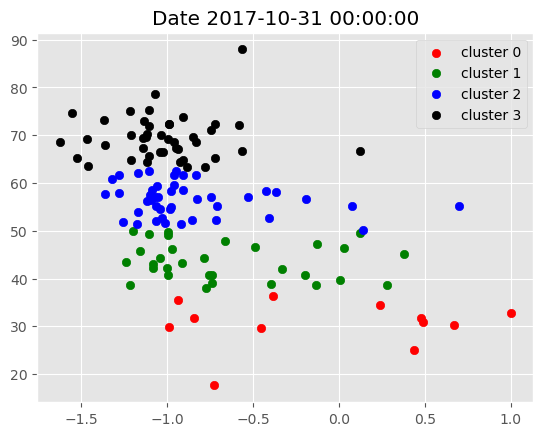

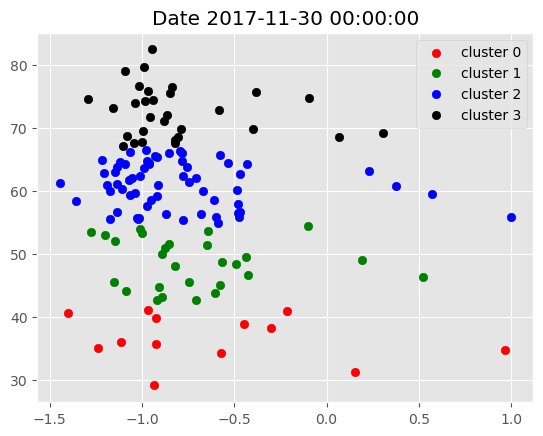

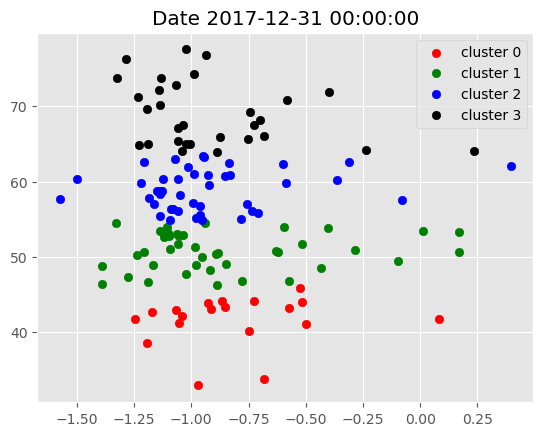

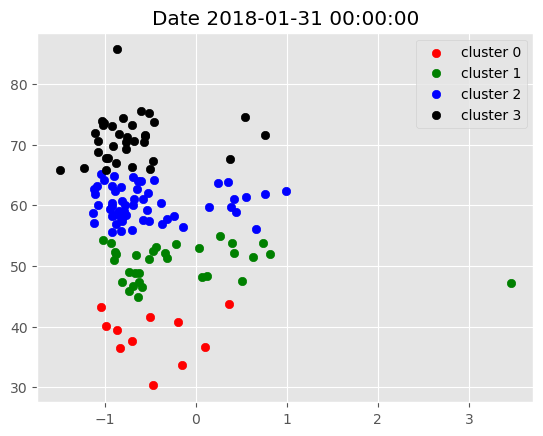

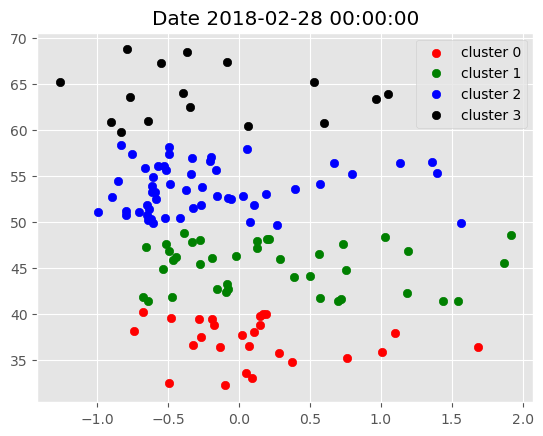

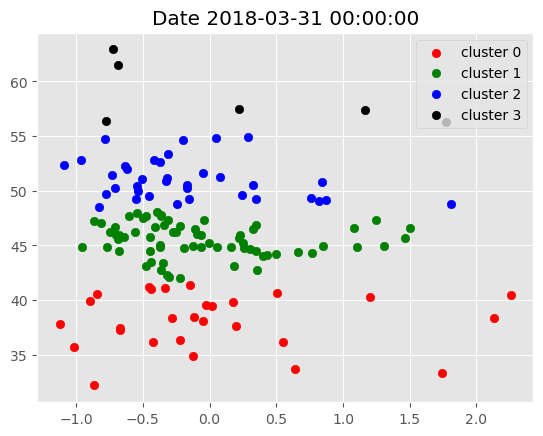

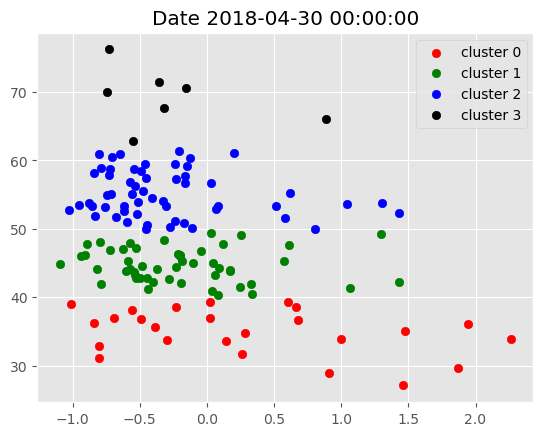

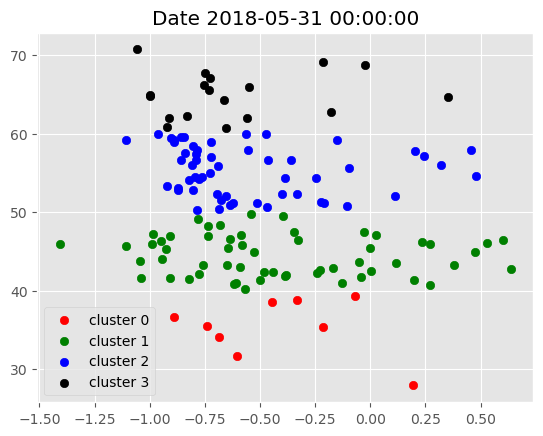

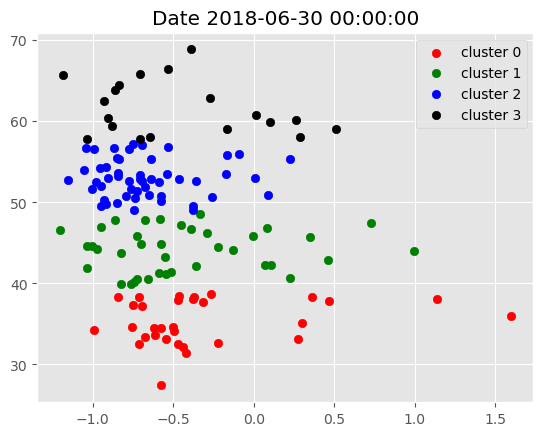

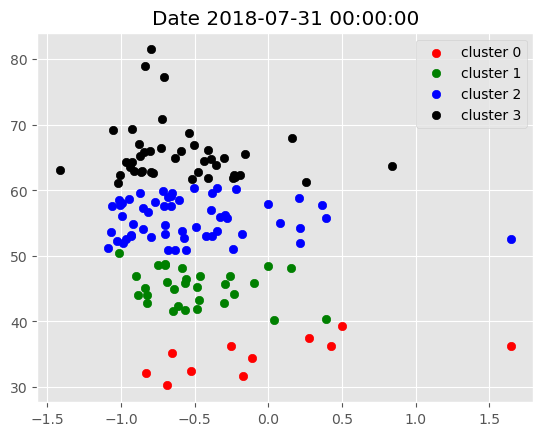

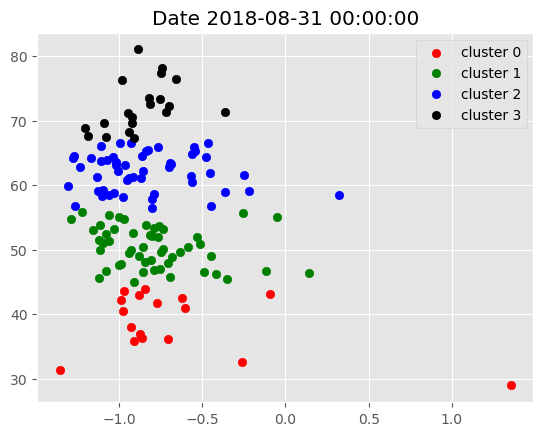

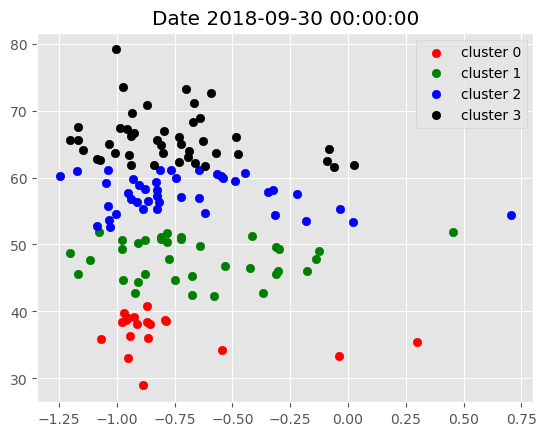

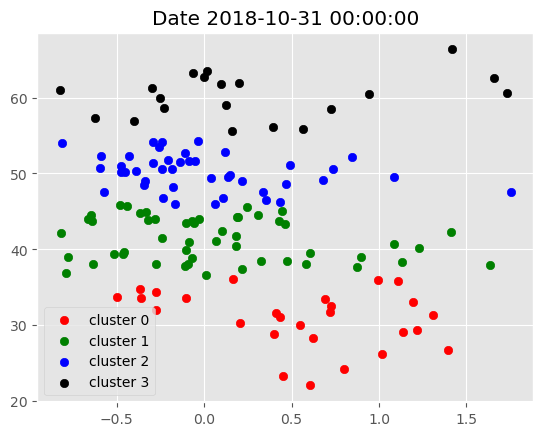

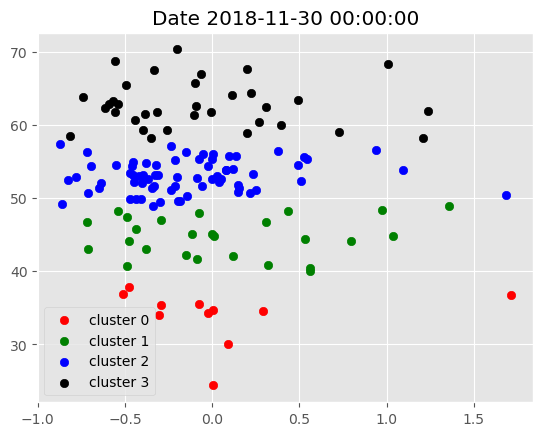

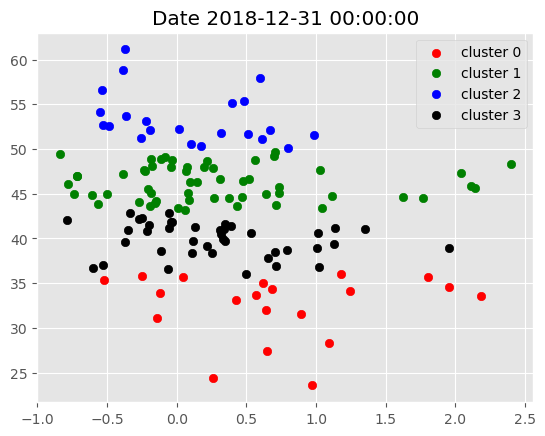

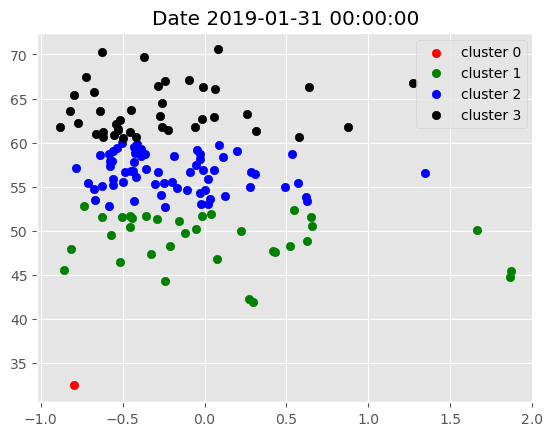

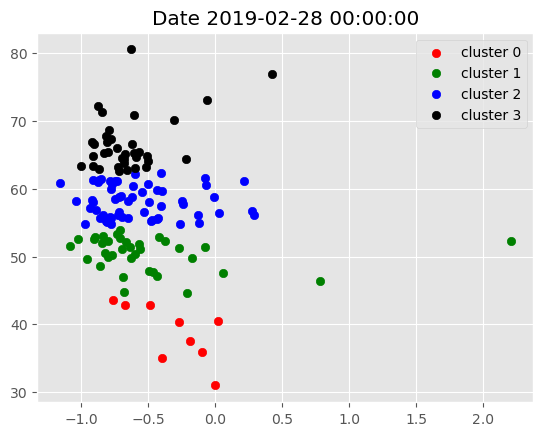

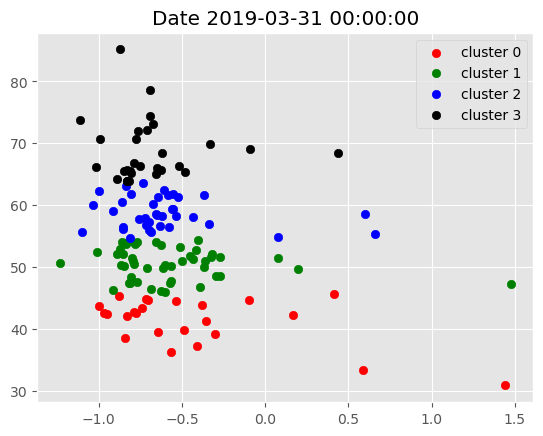

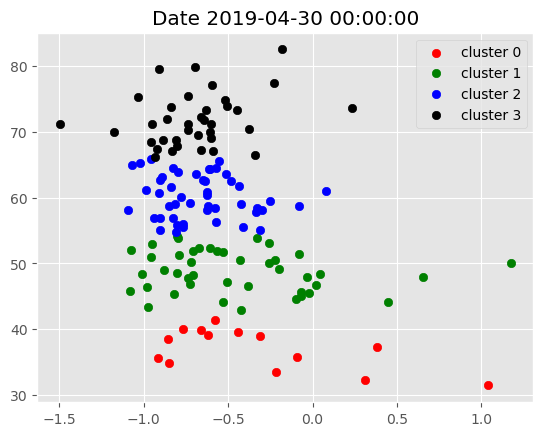

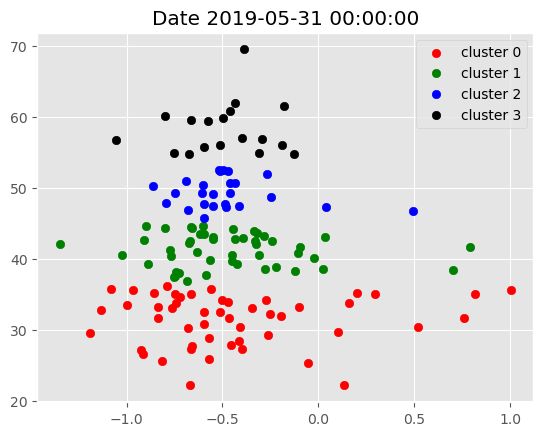

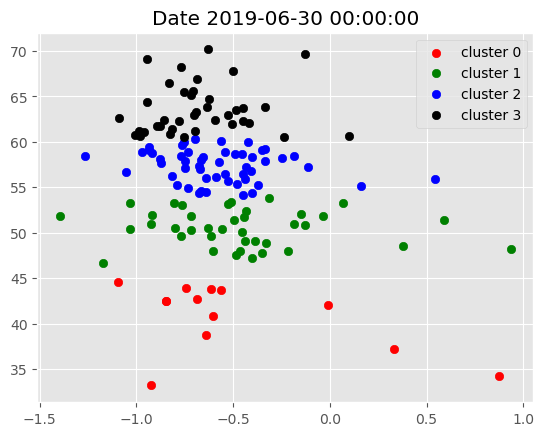

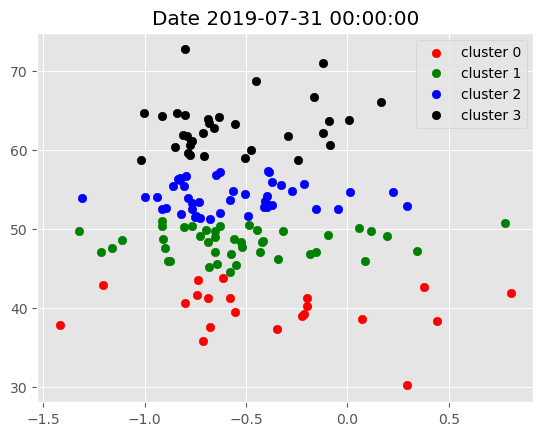

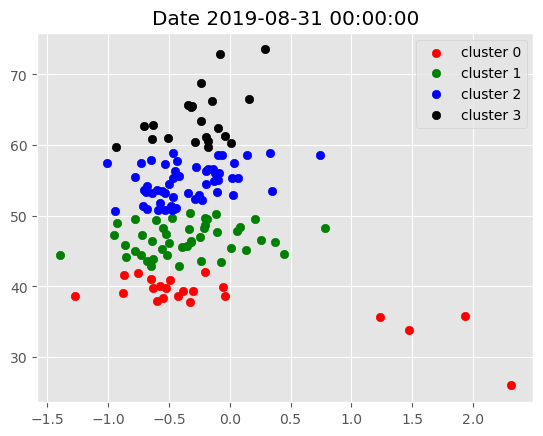

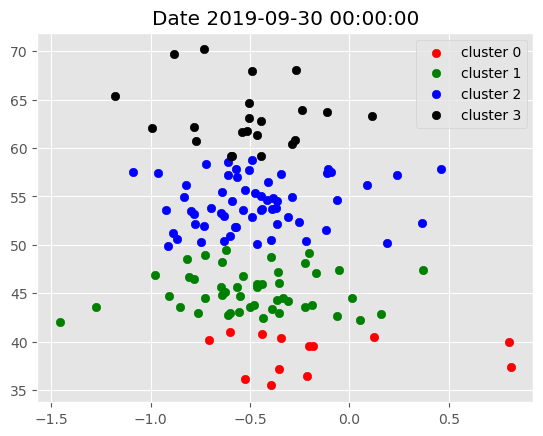

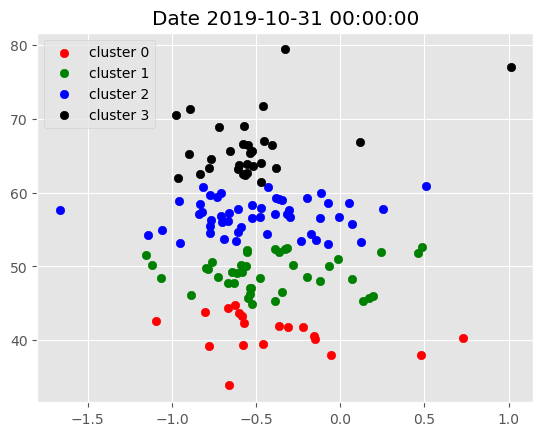

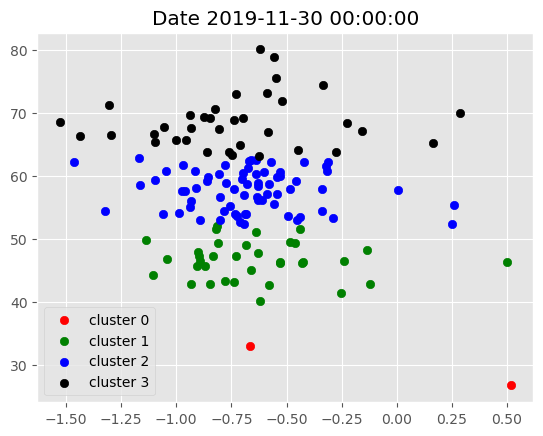

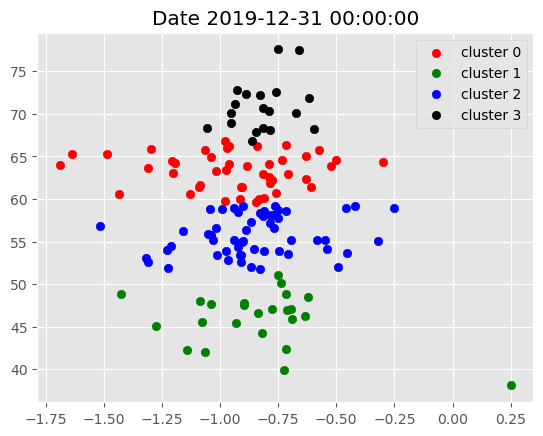

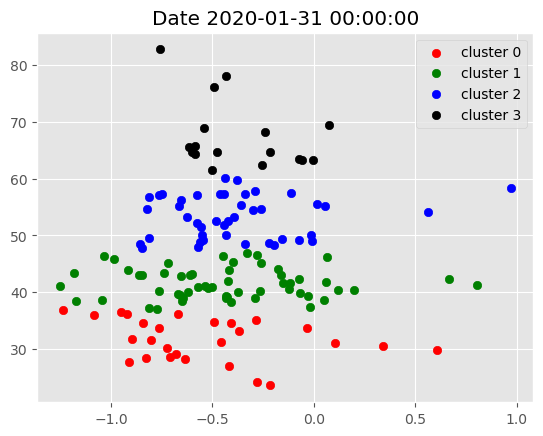

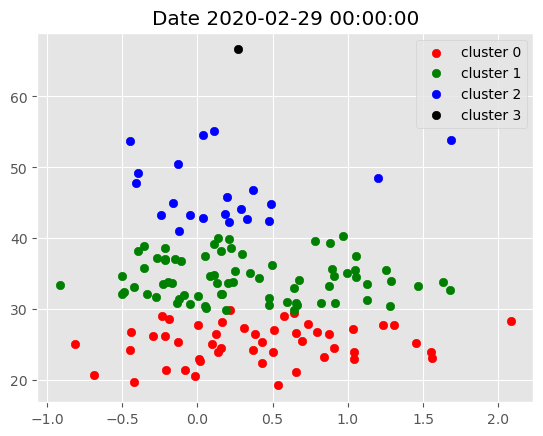

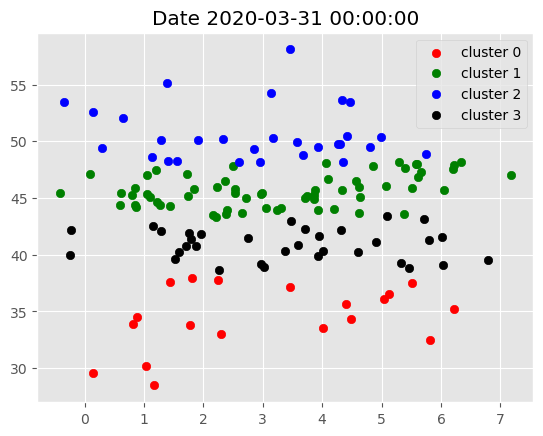

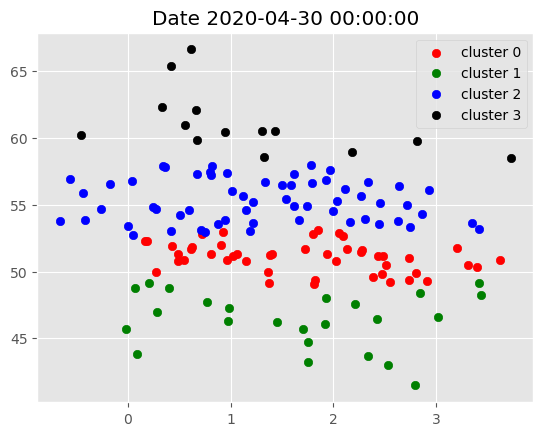

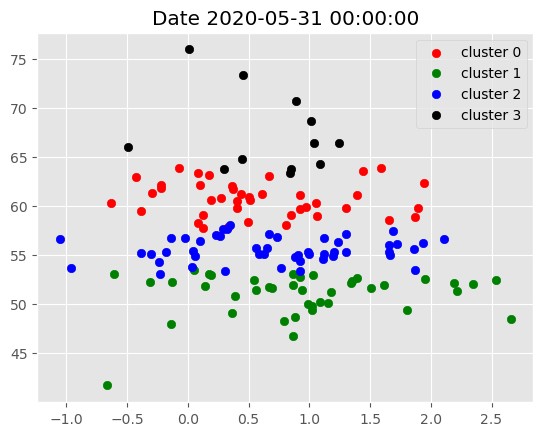

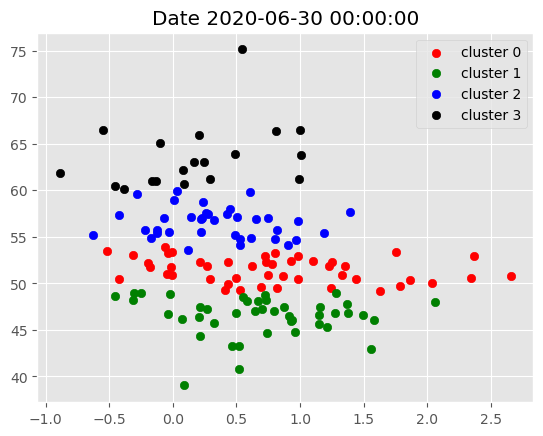

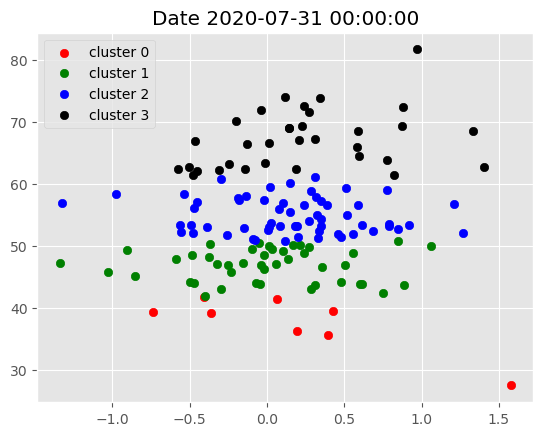

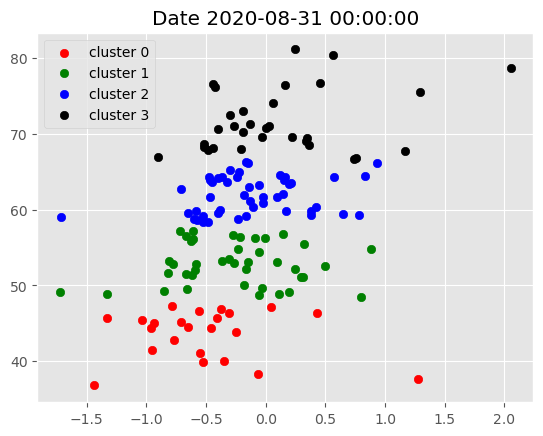

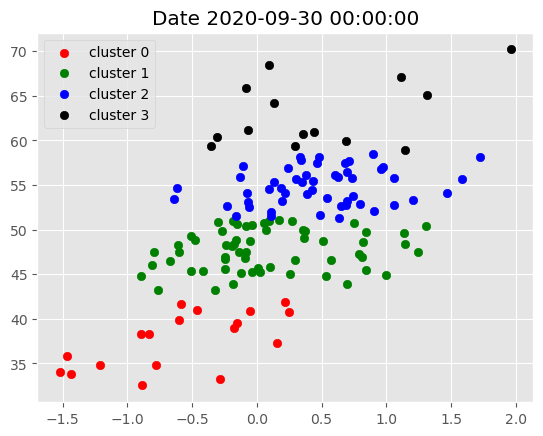

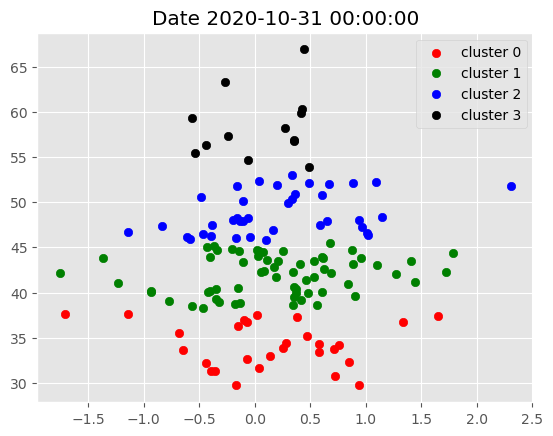

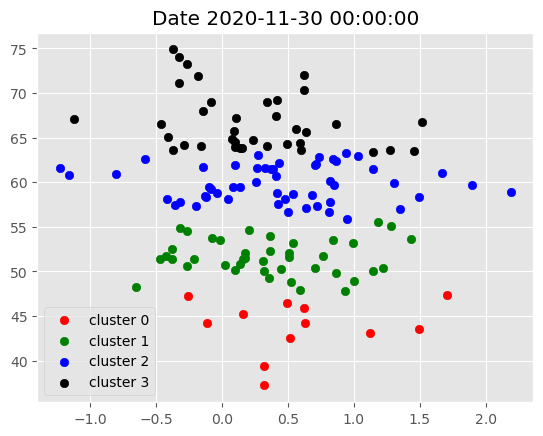

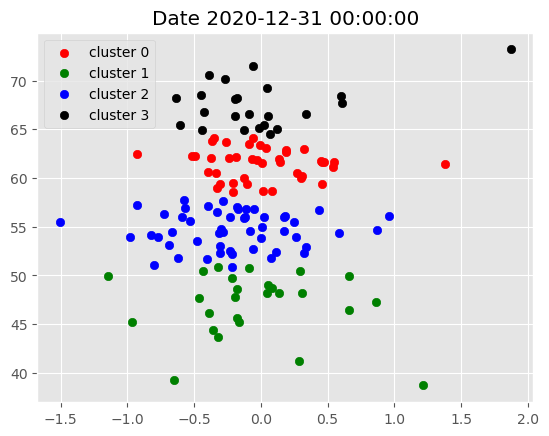

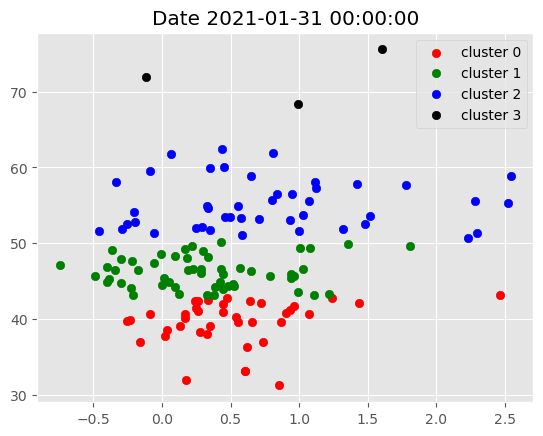

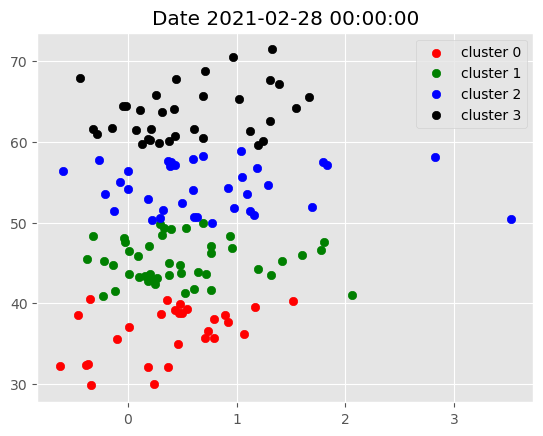

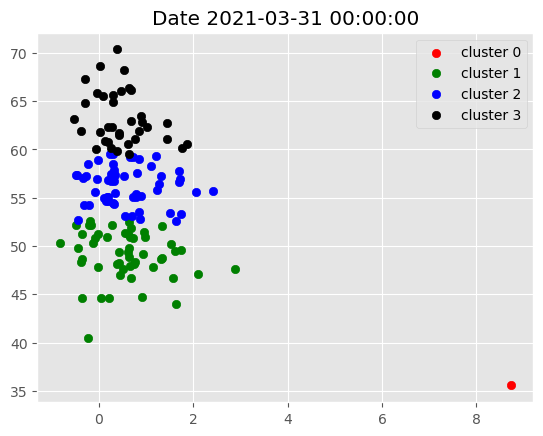

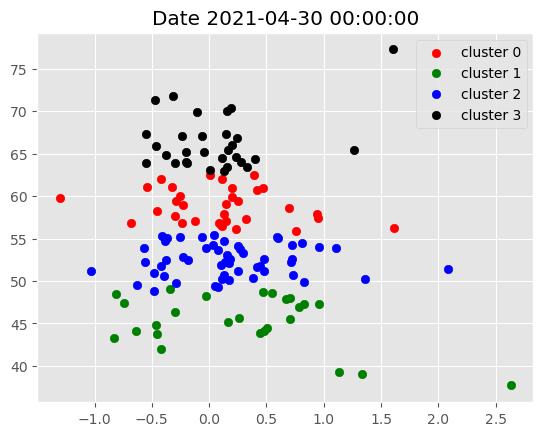

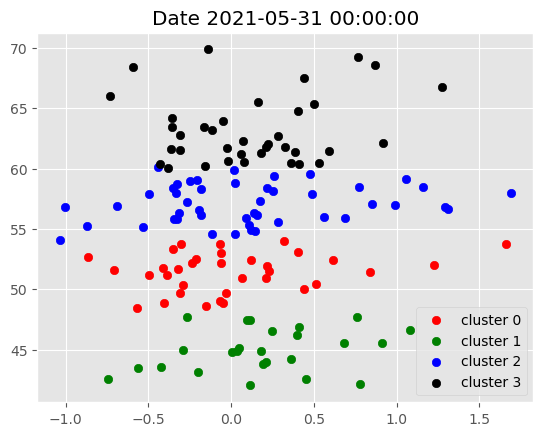

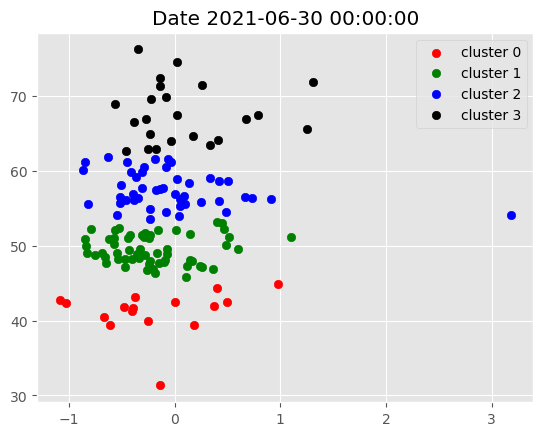

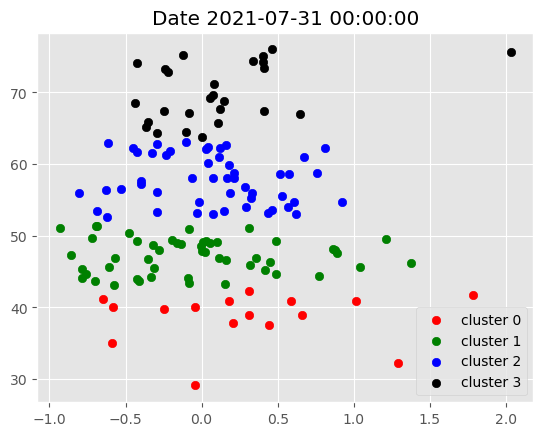

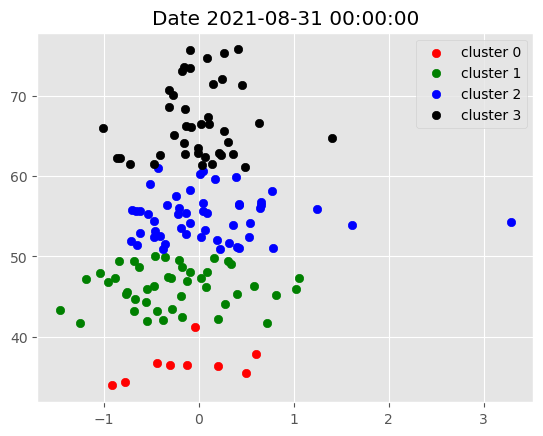

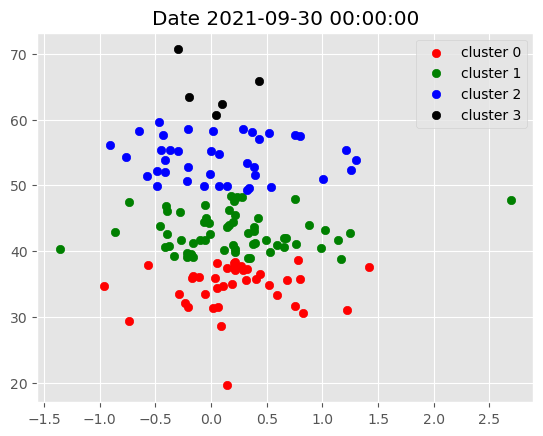

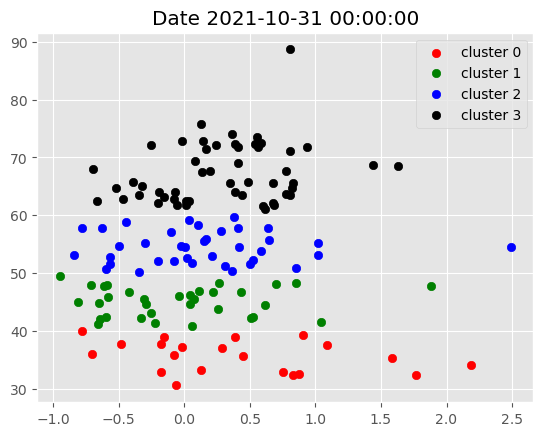

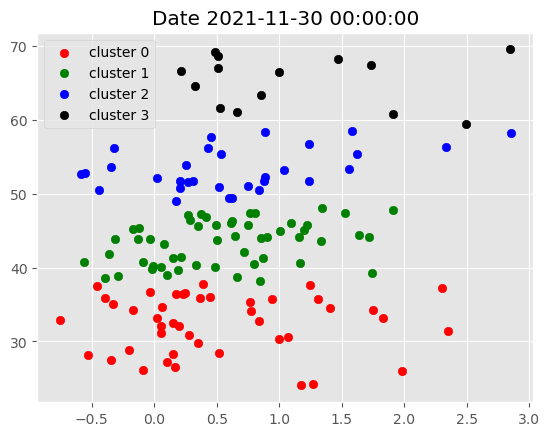

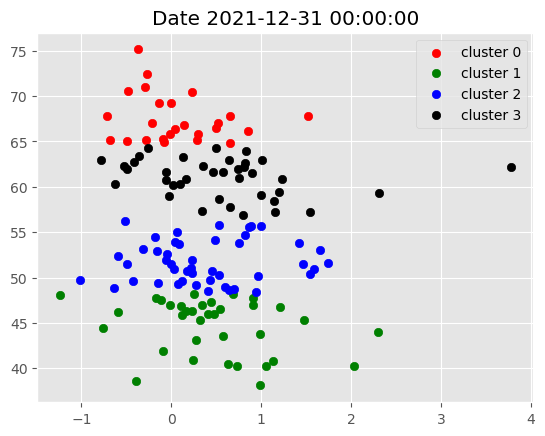

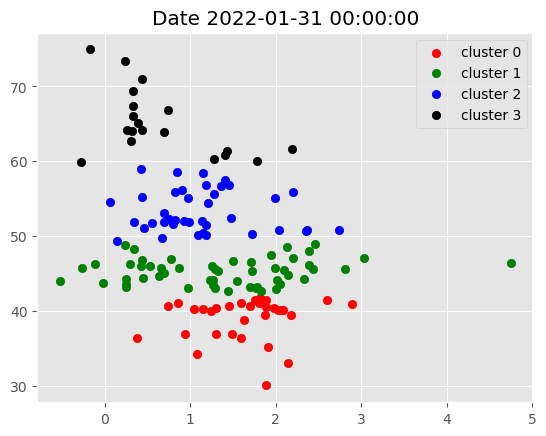

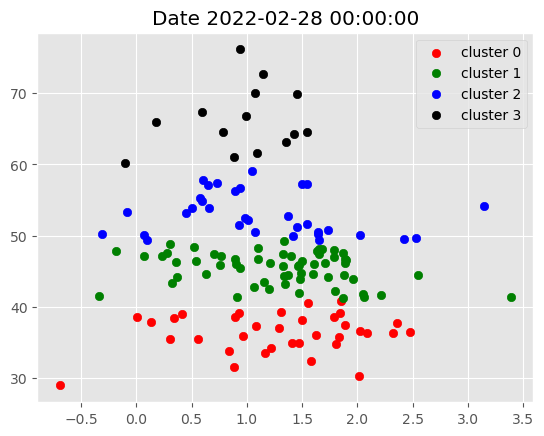

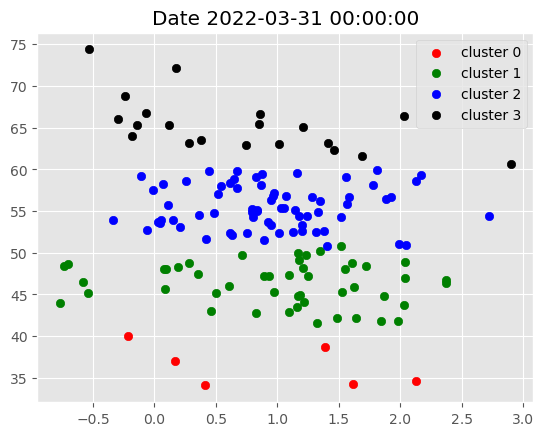

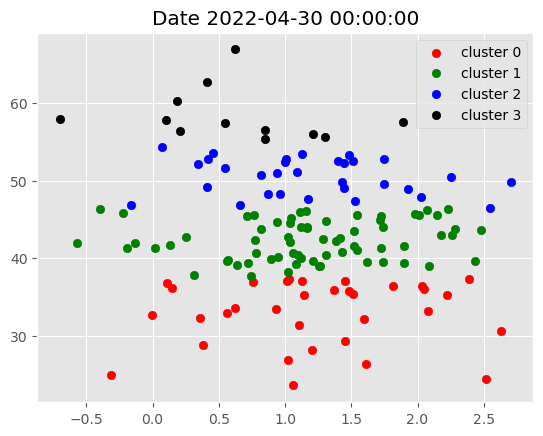

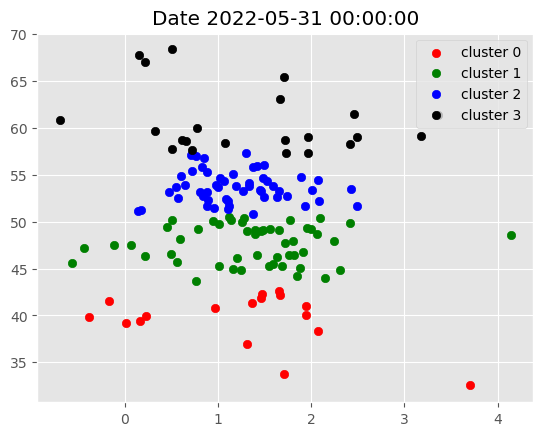

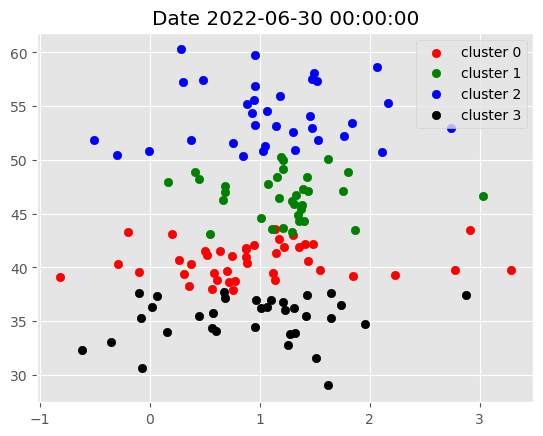

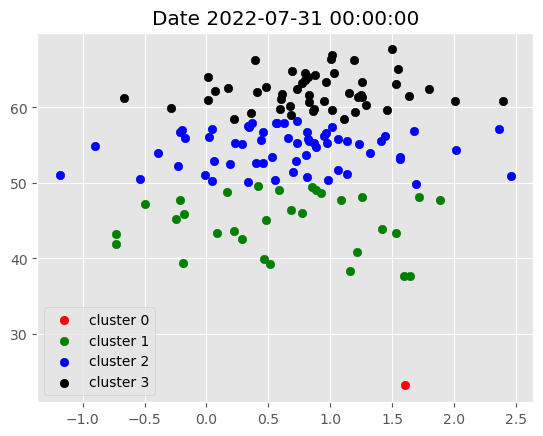

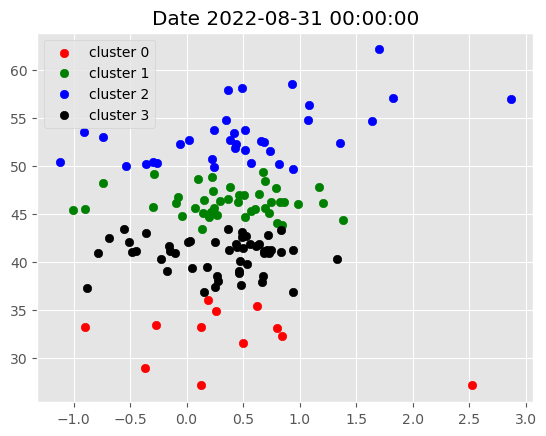

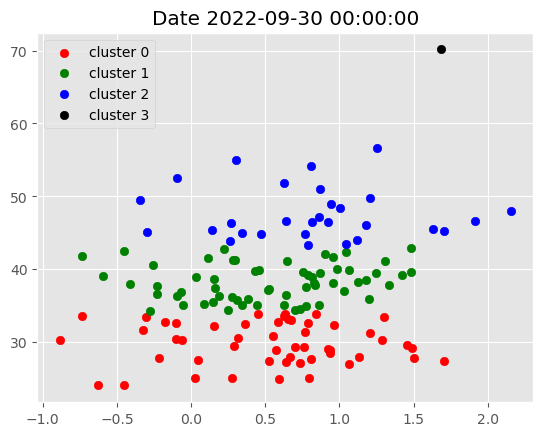

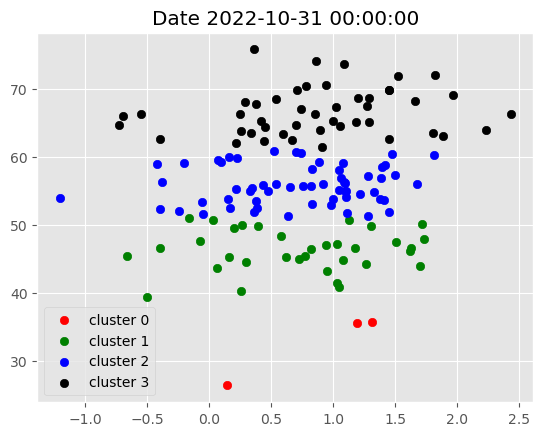

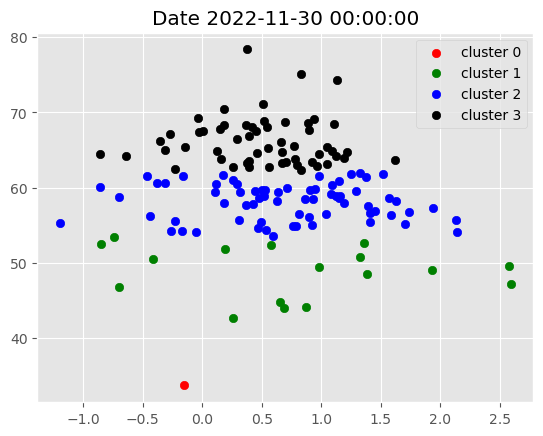

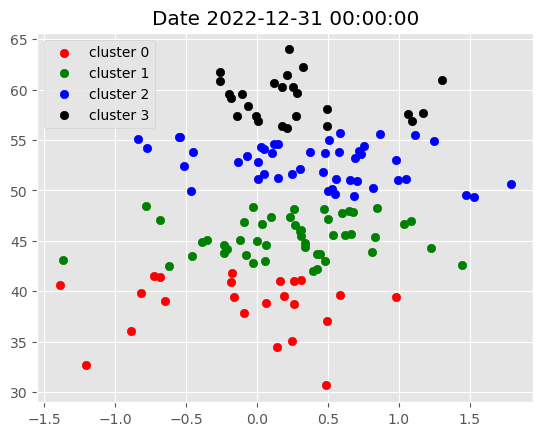

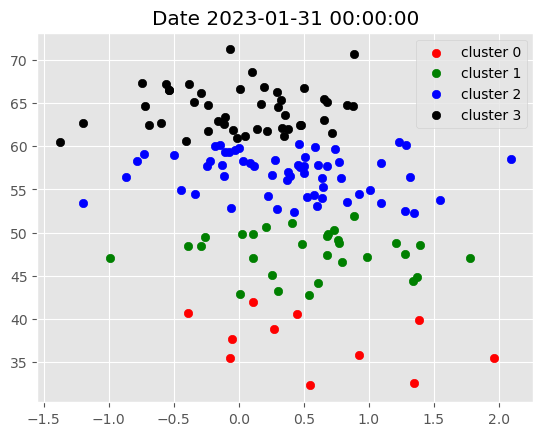

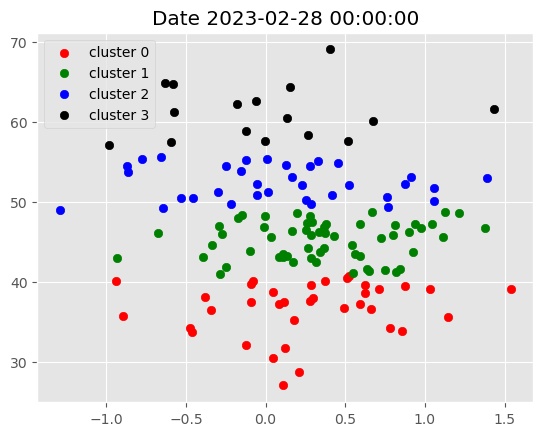

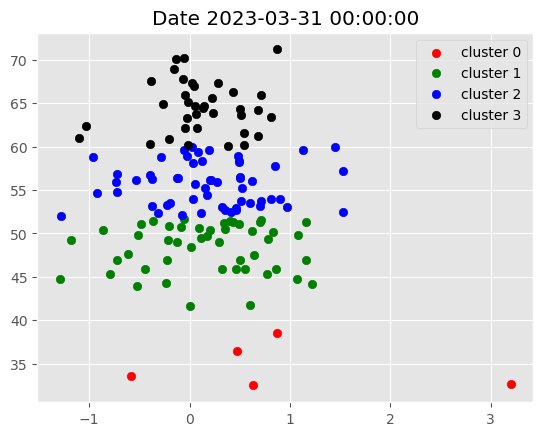

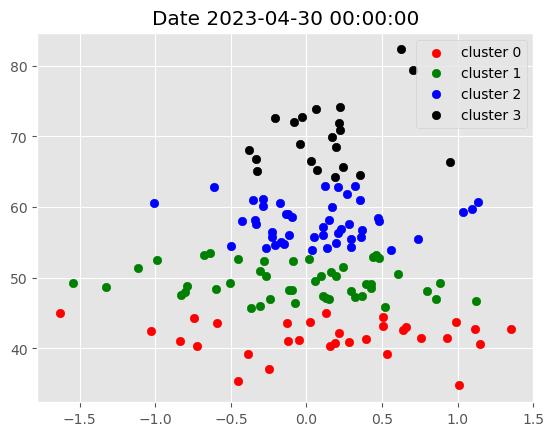

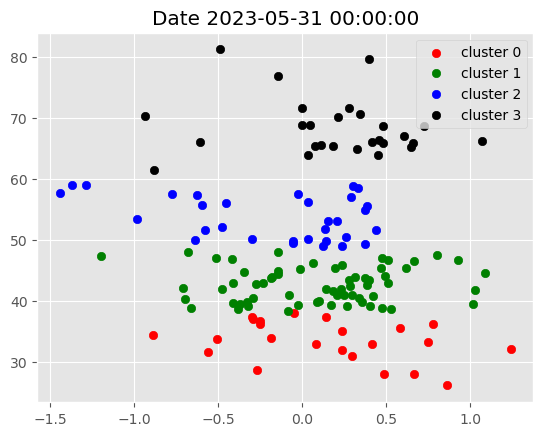

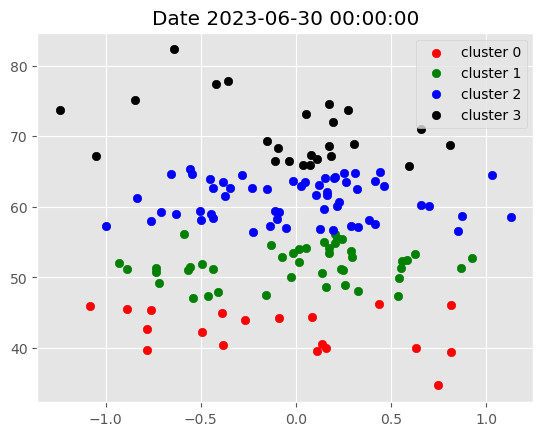

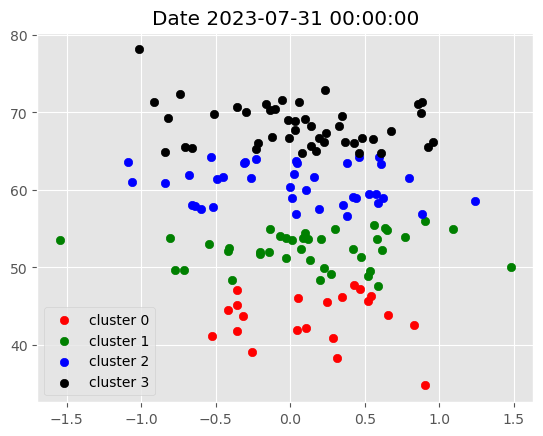

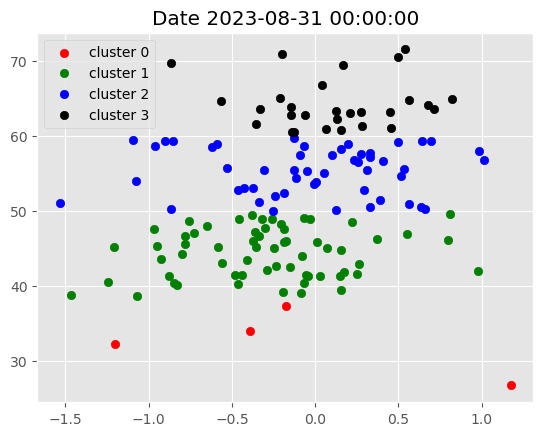

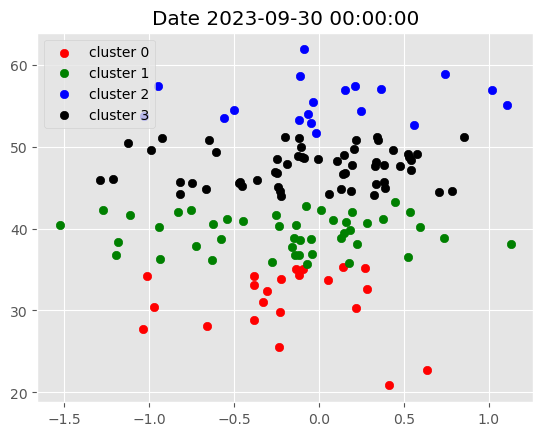

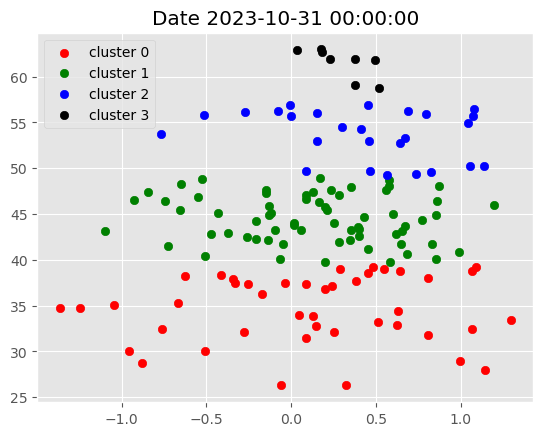

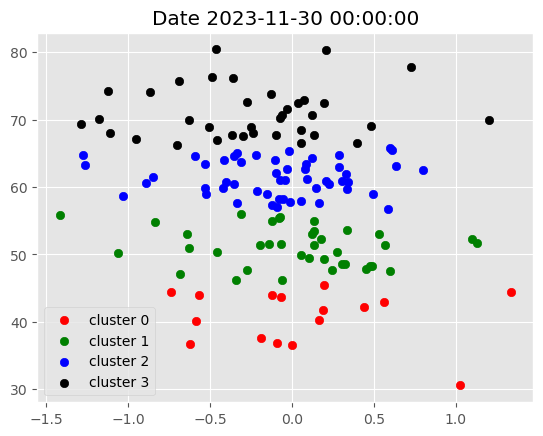

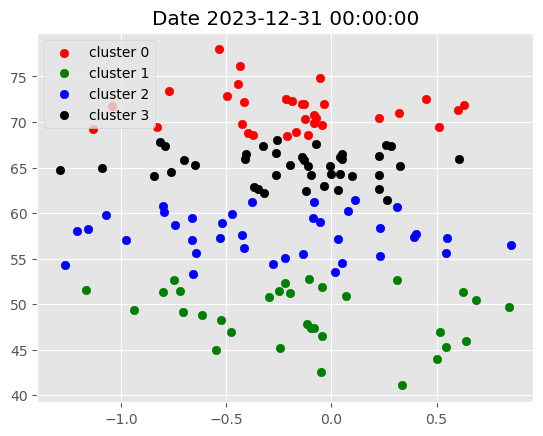

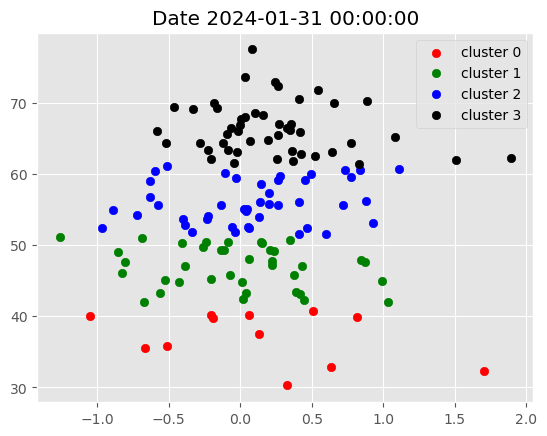

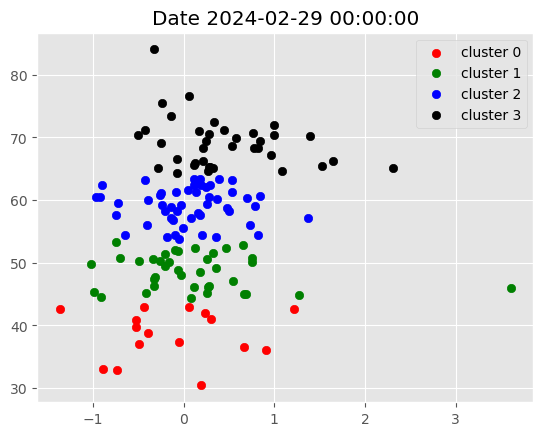

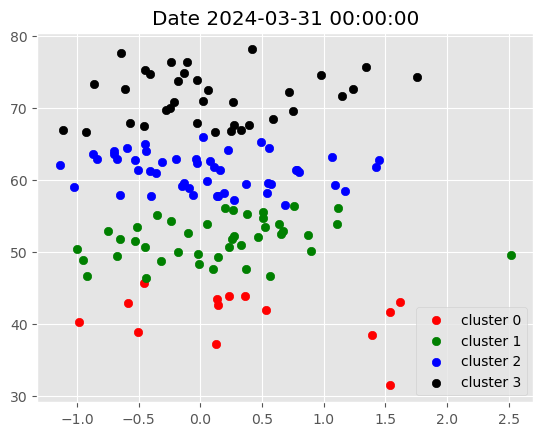

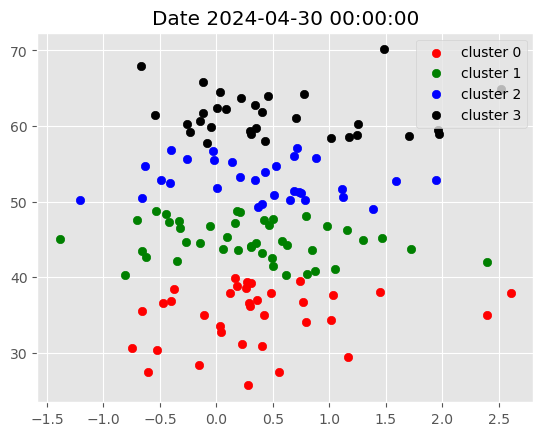

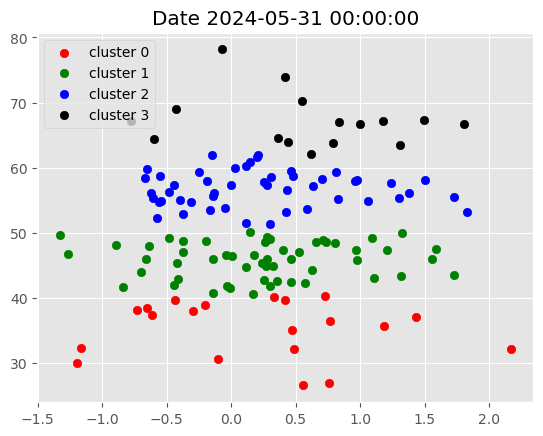

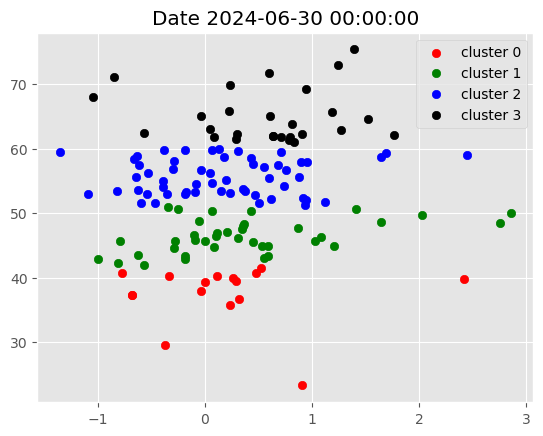

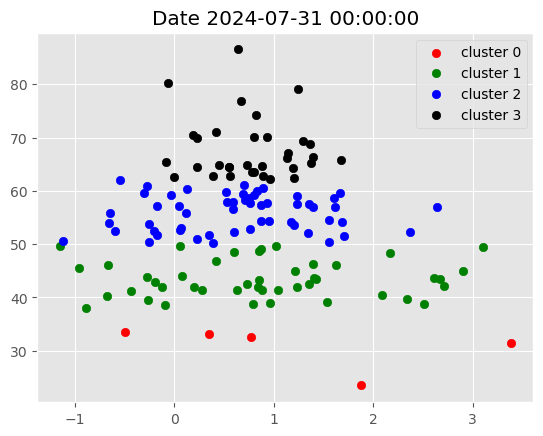

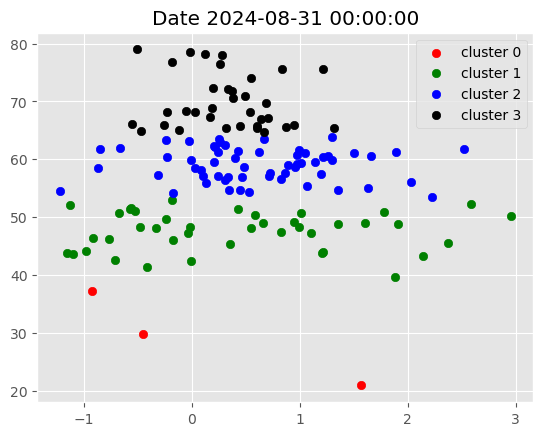

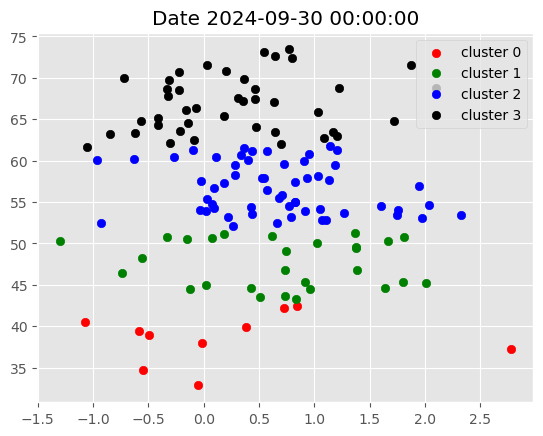

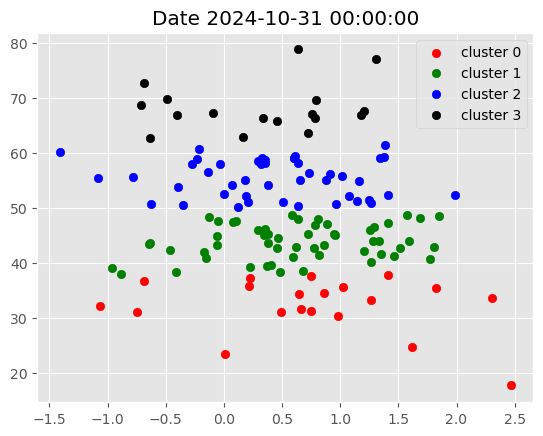

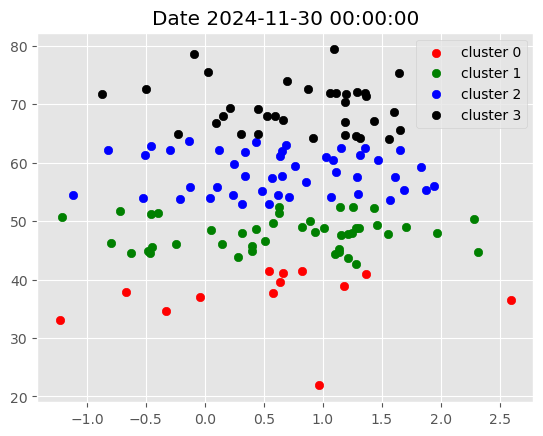

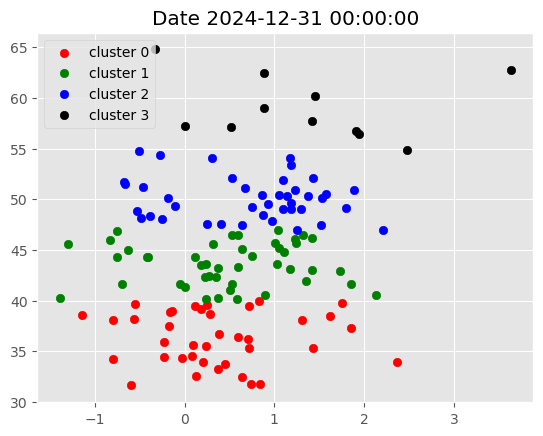

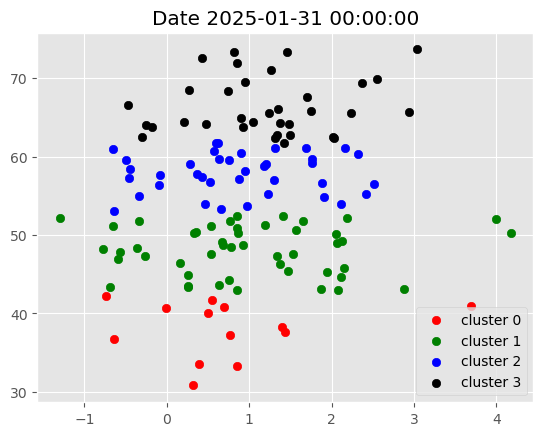

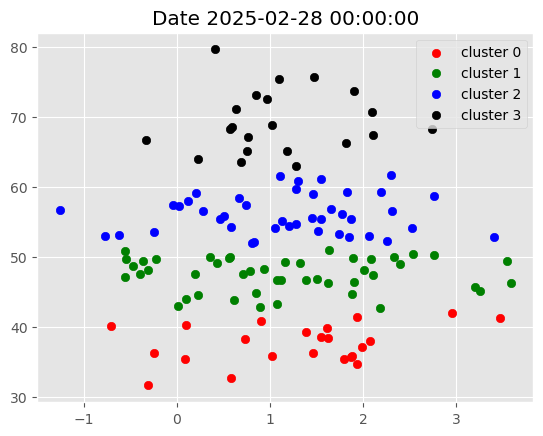

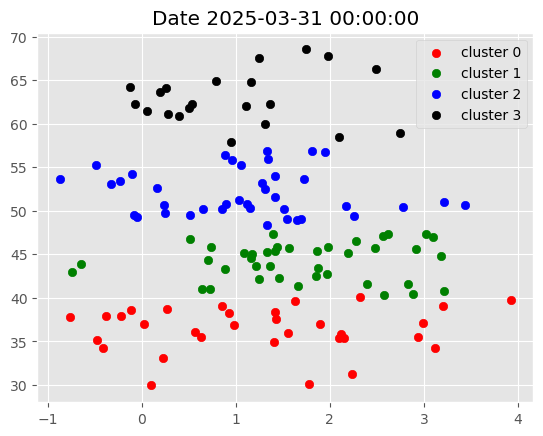

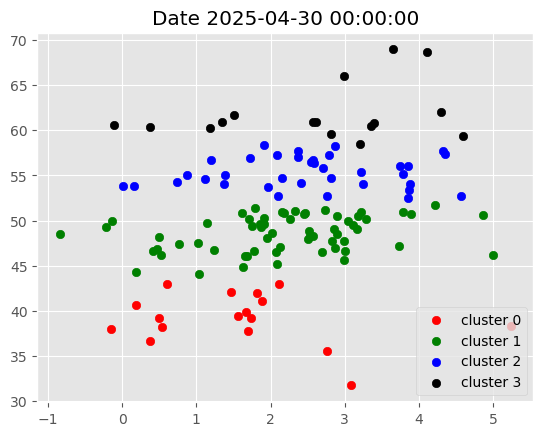

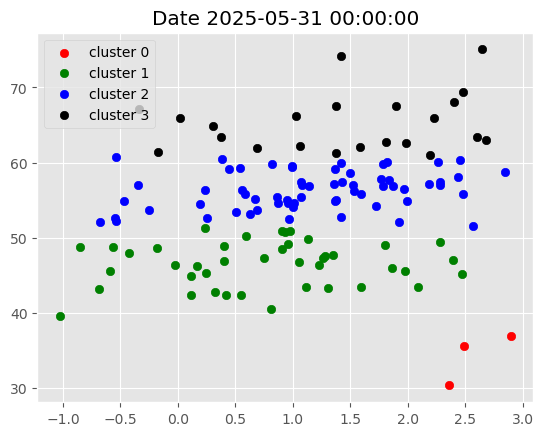

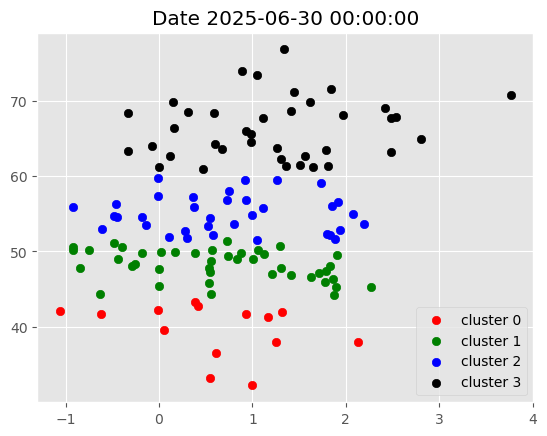

In [127]:
plt.style.use('ggplot')
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i,level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)
#higher rsi means more bullish momentum

In [128]:
#selecting stocks in cluster 3
filtered_df = data[data['cluster'] == 3].copy()
#removing ticker index
filtered_df = filtered_df.reset_index(level=1)
#converting last date of month to first date of next month
filtered_df.index = filtered_df.index+pd.DateOffset(1)
#re applying ticker index
filtered_df = filtered_df.reset_index().set_index(['date','ticker'])
#get dates
dates = filtered_df.index.get_level_values('date').unique().tolist()

In [129]:
#creating a dictionary with keys as dates and values as list of stocks we want to buy at the start of each month
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level = 0).index.tolist()
fixed_dates

{'2017-09-01': ['AAPL',
  'ABBV',
  'ABT',
  'ADBE',
  'AMGN',
  'BA',
  'BIIB',
  'BMY',
  'BRK-B',
  'CAT',
  'CCL',
  'CHTR',
  'CRM',
  'DD',
  'DLTR',
  'EA',
  'GILD',
  'GM',
  'HUM',
  'ISRG',
  'LMT',
  'MA',
  'MCD',
  'META',
  'MSFT',
  'NEE',
  'NXPI',
  'PFE',
  'PG',
  'PYPL',
  'TMO',
  'UNH',
  'V'],
 '2017-10-01': ['ABBV',
  'AMAT',
  'AXP',
  'AZO',
  'BA',
  'BLK',
  'BMY',
  'BSX',
  'C',
  'CAT',
  'COP',
  'CVX',
  'DG',
  'DLTR',
  'EOG',
  'F',
  'FDX',
  'GM',
  'GS',
  'HAL',
  'HD',
  'INTC',
  'LLY',
  'LMT',
  'MAR',
  'MET',
  'MU',
  'OXY',
  'PFE',
  'SCHW',
  'SLB',
  'TXN',
  'UNP',
  'UPS',
  'VLO',
  'WFC',
  'XOM'],
 '2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'LRCX',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'O

In [130]:
#define portfolio optimization function
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
#we will assign weights to stocks on basis of sharpe(more sharpe gets more weight)
def optimize_weights(prices, lower_bound=0):
    #calculate expected returns
    returns = expected_returns.mean_historical_return(prices=prices,frequency=252)
    #calculate covariance
    cov = risk_models.sample_cov(prices=prices,frequency=252)
    #initializing the efficient frontier object
    ef = EfficientFrontier(expected_returns=returns,
                          cov_matrix=cov,
                          weight_bounds=(lower_bound,.1),
                          solver='SCS')
    #calculating the weight of the stock
    weights = ef.max_sharpe()
    return ef.clean_weights()


In [131]:
#downloading fresh daily prices data only for short listed stocks
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers = stocks, start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                    end=data.index.get_level_values('date').unique()[-1],auto_adjust=False)
new_df

[*********************100%***********************]  163 of 163 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2016-08-31   24.380812   44.219086         NaN   35.773876   99.638145   
2016-09-01   24.525581   44.170795         NaN   36.012260   99.690140   
2016-09-02   24.755379   44.232887         NaN   35.833477  100.210007   
2016-09-06   24.748480   44.570900         NaN   35.893066   99.950073   
2016-09-07   24.900145   44.819252         NaN   35.671722   99.742119   
...                ...         ...         ...         ...         ...   
2025-06-18  196.580002  185.490005  132.169998  132.410004  306.380005   
2025-06-20  201.000000  185.300003  131.729996  132.990005  285.369995   
2025-06-23  201.500000  183.759995  130.529999  133.259995  295.000000   
2025-06-24  200.300003  185.550003  132.149994  138.080002  300.720001   
2025-06-25  201.559998  185.429993  129.669998  137.399994  294.730011   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2016-08-31  102.309998   52.875328   74.177521   67.400002  47.652401  ...   
2016-09-01  102.900002   53.297928   74.854774   67.370003  47.317883  ...   
2016-09-02  103.570000   53.373993   74.656563   68.010002  47.676289  ...   
2016-09-06  103.500000   53.019009   74.218826   67.690002  47.349743  ...   
2016-09-07  103.000000   52.106197   74.742233   68.599998  47.286022  ...   
...                ...         ...         ...         ...        ...  ...   
2025-06-18  378.040009  229.649994  306.769989  295.190002  84.250000  ...   
2025-06-20  376.920013  228.350006  306.260010  297.209991  85.129997  ...   
2025-06-23  380.119995  230.979996  310.239990  300.950012  85.820000  ...   
2025-06-24  382.339996  234.979996  311.399994  304.190002  85.459999  ...   
2025-06-25  387.549988  234.679993  298.190002  302.369995  83.919998  ...   

Price        Volume                                                            \
Ticker          VLO     VRTX        VZ       WBA     WDAY       WDC       WFC   
Date                                                                            
2016-08-31  5006200   797500  10390500   3282700  1418600   4414190  24533600   
2016-09-01  5281500   966600   9988800   3296100  3605500   3988977  17017100   
2016-09-02  4872900   843100  13275300   3029600  2471100   3731654  12684000   
2016-09-06  3554000   877600  17235600   3726000  2077900   5972154  21832200   
2016-09-07  4613600   928300  10612300   3315900  1766100  24617193  12437300   
...             ...      ...       ...       ...      ...       ...       ...   
2025-06-18  2872700  1380300  18654200   4933900  2472700   6647400  23498300   
2025-06-20  5438600  2167300  37068100  13458800  5155600   9426300  27677500   
2025-06-23  3229200   949800  16014400   8997300  1750700   4627000  17375700   
2025-06-24  2973200  1068000  16716300   8140300  2478100   6021000  16342300   
2025-06-25  1791549  1006479  12547285   5527930  1824384   4293170  11832320   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-08-31  18934800  2146500  12491400  
2016-09-01  35284200  6805000   8434700  
2016-09-02  24248700  3025400   7099600  
2016-09-06  28712700  2029900   9851200  
2016-09-07  28854900  2617000   7470400  
...              ...      ...       ...  
2025-06-18  11333700  1256900  17968900  
2025-06-20  20604900  2841500  36273300  
2025-06-23  20432400  1862300  26631100  
2025-06-24  22403700  1765700  24828300  
2025-06-25   9233434  1728137  12729599  

[2216 rows x 978 columns]

In [132]:
#printing the column names of the new dataframe
columns_level_1 = new_df.columns.get_level_values(0).unique()
print(columns_level_1)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [133]:
#calculating returns per day
returns_dataframe = np.log(new_df['Adj Close']).diff()
#initializing portfolio dataframe
portfolio_df = pd.DataFrame()
#showing returns
returns_dataframe

Ticker,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADP,ADSK,AIG,...,VLO,VRTX,VZ,WBA,WDAY,WDC,WFC,WMT,WYNN,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01,0.005920,-0.001093,NaN,0.006642,0.000522,0.005750,0.007961,0.009089,-0.000445,-0.007045,...,-0.019336,0.002536,0.004385,0.010232,0.035908,-0.007528,-0.007310,0.019407,0.042201,-0.003449
2016-09-02,0.009326,0.001405,NaN,-0.004977,0.005201,0.006490,0.001426,-0.002651,0.009455,0.007546,...,0.009897,0.003792,0.006070,0.008305,0.012326,0.013935,0.002377,-0.004679,-0.008515,0.006657
2016-09-06,-0.000279,0.007613,NaN,0.001662,-0.002597,-0.000676,-0.006673,-0.005881,-0.004716,-0.006873,...,0.007993,0.007020,0.011843,-0.007079,0.012508,0.012273,-0.011140,0.006873,0.004429,0.013069
2016-09-07,0.006110,0.005557,NaN,-0.006186,-0.002083,-0.004843,-0.017367,0.007027,0.013354,-0.001347,...,0.014727,-0.001881,0.003731,0.015074,-0.009143,0.114155,-0.004411,-0.012961,0.016672,-0.003733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18,0.004793,0.000054,-0.009038,0.000982,-0.018273,-0.012199,0.009670,-0.002767,-0.005608,0.000356,...,-0.016715,0.014398,-0.004310,0.000000,-0.024272,0.010530,0.030429,0.008873,-0.004248,-0.007131
2025-06-20,0.022235,-0.001025,-0.003335,0.004371,-0.071040,-0.002967,-0.005677,-0.001664,0.006820,0.010391,...,0.011978,-0.016936,0.000720,-0.007048,0.005515,0.001688,0.008792,0.010774,0.018016,0.013252
2025-06-23,0.002484,-0.008346,-0.009151,0.002028,0.033189,0.008454,0.011452,0.012912,0.012505,0.008073,...,-0.029050,0.006038,0.015703,0.003530,-0.006782,0.018217,0.021128,0.018043,0.013581,-0.026145


In [134]:
for start_date in fixed_dates.keys():
    try:
        #end date is the last day of the month
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        #selected stocks for the month
        cols = fixed_dates[start_date]
        #optimizing for 1 year previous data
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        #in case optimization fails due to lack of data
        success = False
        try:
            weights = optimize_weights(prices=optimization_df, lower_bound = round(1/(len(optimization_df.columns)*2),3))
            weights = pd.DataFrame(weights, index=pd.Series(0))
            #if sufficient data is there to calculate weights
            success = True
        except:
            print(f'Max sharpie optimization failed for {start_date}, continuing with equal weights')
        if success == False:
            #we give equal weights to stocks when insufficient data
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                  index=optimization_df.columns.tolist(),
                                  columns=pd.Series(0)).T
        temp_df = returns_dataframe[start_date:end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                    .merge(weights.stack().to_frame('weight').reset_index(level=0,drop=True),
                          left_index=True,
                          right_index=True)\
                    .reset_index().set_index(['Date','Ticker']).unstack().stack()
        temp_df.index.names = ['date','ticker']
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        #portfolio dataframe
        portfolio_df = pd.concat([portfolio_df,temp_df], axis=0)
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()
portfolio_df

Max sharpie optimization failed for 2018-04-01, continuing with equal weights
Max sharpie optimization failed for 2018-05-01, continuing with equal weights
Max sharpie optimization failed for 2020-03-01, continuing with equal weights
Max sharpie optimization failed for 2020-04-01, continuing with equal weights
Max sharpie optimization failed for 2021-02-01, continuing with equal weights
Max sharpie optimization failed for 2021-10-01, continuing with equal weights
Max sharpie optimization failed for 2022-07-01, continuing with equal weights
Max sharpie optimization failed for 2022-09-01, continuing with equal weights
Max sharpie optimization failed for 2022-10-01, continuing with equal weights
Max sharpie optimization failed for 2023-11-01, continuing with equal weights
'return'


,Strategy Return
date,
2017-09-01,0.000684
2017-09-05,-0.005974
2017-09-06,-0.001899
2017-09-07,0.006845
2017-09-08,-0.001337
...,...
2025-06-18,-0.010054
2025-06-20,-0.003056
2025-06-23,0.012644


In [135]:
#visualize portfolio returns and compare to SP500 returns
spy = yf.download(tickers='SPY',
                 start=pd.to_datetime(dt.date.today()) - pd.DateOffset(365*10),
                 end=dt.date.today(),auto_adjust=False)
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'},axis=1)
spy_ret.columns = spy_ret.columns.get_level_values(0)  # Extract single-level column names
portfolio_df = portfolio_df.merge(spy_ret,
                                 left_index=True,
                                 right_index=True)
portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-09-01,0.000684,0.001413
2017-09-05,-0.005974,-0.007208
2017-09-06,-0.001899,0.003408
2017-09-07,0.006845,-0.000121
2017-09-08,-0.001337,-0.001175
...,...,...
2025-06-18,-0.010054,-0.000151
2025-06-20,-0.003056,-0.002351
2025-06-23,0.012644,0.009829
2025-06-24,0.014287,0.010987


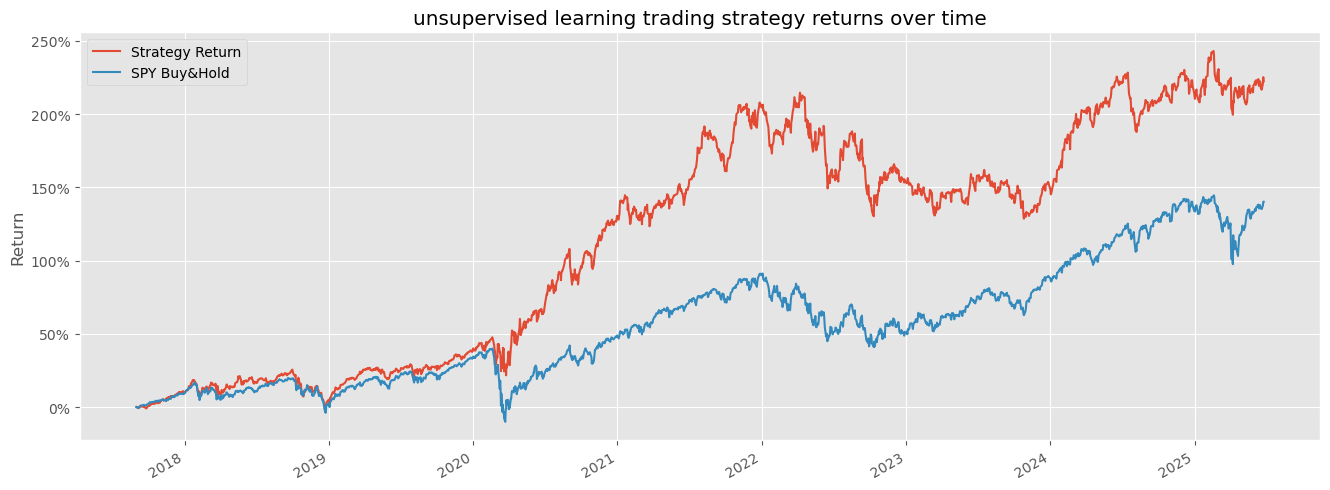

In [136]:
#plotting graph between our portfolio strategy returns and returns we get if we put equal weight in all SP500 stocks
import matplotlib.ticker as mtick
plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return[:dt.date.today()].plot(figsize=(16,6))
plt.title('unsupervised learning trading strategy returns over time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()

1.2332413093626466

In [137]:
difference = portfolio_df['Strategy Return'].sum() - portfolio_df['SPY Buy&Hold'].sum()
difference/portfolio_df['SPY Buy&Hold'].sum()

0.2949081389539247